<a href="https://colab.research.google.com/github/ybyun8/HRI_nav/blob/main/Copy_of_A_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Performing the Dynamic Window Algorithm

## Installation

In [ ]:
# @title Installation

!curl -L https://raw.githubusercontent.com/facebookresearch/habitat-sim/master/examples/colab_utils/colab_install.sh | NIGHTLY=true bash -s &> /dev/null
!wget -c http://dl.fbaipublicfiles.com/habitat/mp3d_example.zip && unzip -o mp3d_example.zip -d /content/habitat-sim/data/scene_datasets/mp3d/ &> /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2470  100  2470    0     0  20756      0 --:--:-- --:--:-- --:--:-- 20583
--2020-12-02 02:52:51--  http://dl.fbaipublicfiles.com/habitat/mp3d_example.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67764531 (65M) [application/zip]
Saving to: ‘mp3d_example.zip’

mp3d_example.zip    100%[===================>]  64.62M  19.5MB/s    in 3.3s    

2020-12-02 02:52:55 (19.5 MB/s) - ‘mp3d_example.zip’ saved [67764531/67764531]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Colab Setup and Imports { display-mode: "form" }
# @markdown (double click to see the code)

import math
import os
import random
import sys

import git
import imageio
import magnum as mn
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

# function to display the topdown map
from PIL import Image

import habitat_sim
from habitat_sim.utils import common as utils
from habitat_sim.utils import viz_utils as vut

%cd /content/habitat-sim

if "google.colab" in sys.modules:
    # This tells imageio to use the system FFMPEG that has hardware acceleration.
    os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"

repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
%cd $dir_path
data_path = os.path.join(dir_path, "data")
# @markdown Optionally configure the save path for video output:
output_directory = "examples/tutorials/nav_output/"  # @param {type:"string"}
output_path = os.path.join(dir_path, output_directory)
if not os.path.exists(output_path):
    os.mkdir(output_path)

/content/habitat-sim
/content/habitat-sim


In [ ]:
# @title Define Observation Display Utility Function { display-mode: "form" }

# @markdown A convenient function that displays sensor observations with matplotlib.

# @markdown (double click to see the code)


# Change to do something like this maybe: https://stackoverflow.com/a/41432704
def display_sample(rgb_obs, semantic_obs=np.array([]), depth_obs=np.array([])):
    from habitat_sim.utils.common import d3_40_colors_rgb

    rgb_img = Image.fromarray(rgb_obs, mode="RGBA")

    arr = [rgb_img]
    titles = ["rgb"]
    if semantic_obs.size != 0:
        semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)
        titles.append("semantic")

    if depth_obs.size != 0:
        depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")
        arr.append(depth_img)
        titles.append("depth")

    plt.figure(figsize=(12, 8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i + 1)
        ax.axis("off")
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show(block=False)


if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("--no-display", dest="display", action="store_false")
    parser.add_argument("--no-make-video", dest="make_video", action="store_false")
    parser.set_defaults(show_video=True, make_video=True)
    args, _ = parser.parse_known_args()
    show_video = args.display
    display = args.display
    do_make_video = args.make_video
else:
    show_video = False
    do_make_video = False
    display = False

# import the maps module alone for topdown mapping
if display:
    from habitat.utils.visualizations import maps

In [ ]:
!ls /content/habitat-sim/data/scene_datasets/habitat-test-scenes/

apartment_1.glb      skokloster-castle.glb	van-gogh-room.glb
apartment_1.navmesh  skokloster-castle.navmesh	van-gogh-room.navmesh


## Set the Robot Vacuum Agent

### Vacuum Stats:

*   Radius = 0.33 meters
*   Height = 0.1 meters
*   Speed range = \[-0.5, 1\] meters





## Load All the Human Positions (Manually) Into Here

### Castle Positions

In [186]:
# @title Castle Positions PK
# @markdown (double click to see the code)

PK = [[-4.86510658, 0.20991862, 15.50925732],
	[-5.34234762, 0.20991862, 15.658391],
	[-5.81958866, 0.20991862, 15.80752468],
	[-5.81958866, 0.20991862, 15.80752468],
	[-5.81958866, 0.20991862, 15.80752468],
	[-5.81958866, 0.20991862, 15.80752468],
	[-5.81958866, 0.20991862, 15.80752468],
	[-5.81958866, 0.20991862, 15.80752468],
	[-5.81958866, 0.20991862, 15.80752468],
	[-5.81958866, 0.20991862, 15.80752468],
	[-5.81958866, 0.20991862, 15.80752468],
	[-5.81958866, 0.20991862, 15.80752468],
	[-5.81958866, 0.20991862, 15.80752468],
	[-5.81958866, 0.20991862, 15.80752468],
	[-5.33171892, 0.20991862, 15.91699123],
	[-4.84384918, 0.20991862, 16.02645874],
	[-4.35597944, 0.20991862, 16.13592529],
	[-3.86810946, 0.2099186, 16.24539185],
	[-3.38023949, 0.22444601, 16.3548584],
	[-2.89236951, 0.29136491, 16.46432495],
	[-2.40449953, 0.25109407, 16.5737915],
	[-2.40449953, 0.25109407, 16.5737915],
	[-2.40449953, 0.25109407, 16.5737915],
	[-2.40449953, 0.25109407, 16.5737915],
	[-2.40449953, 0.25109407, 16.5737915],
	[-2.40449953, 0.25109407, 16.5737915],
	[-2.40449953, 0.25109407, 16.5737915],
	[-2.40449953, 0.25109407, 16.5737915],
	[-2.40449953, 0.25109407, 16.5737915],
	[-2.40449953, 0.25109407, 16.5737915],
	[-2.40449953, 0.25109407, 16.5737915],
	[-2.40449953, 0.25109407, 16.5737915],
	[-2.40449953, 0.25109407, 16.5737915],
	[-2.40449953, 0.25109407, 16.5737915],
	[-2.40449953, 0.25109407, 16.5737915],
	[-2.40449953, 0.25109407, 16.5737915],
	[-2.40449953, 0.25109407, 16.5737915],
	[-2.40449953, 0.25109407, 16.5737915],
	[-2.40449953, 0.25109407, 16.5737915],
	[-1.92725837, 0.22073945, 16.42465782],
	[-1.45001721, 0.19038484, 16.27552414],
	[-0.97277606, 0.18955453, 16.12639046],
	[-0.49553487, 0.19520295, 15.97725677],
	[-0.01829368, 0.19409971, 15.82812309],
	[0.13083999, 0.19311829, 16.30536461],
	[0.27997366, 0.19213687, 16.78260612],
	[0.42910731, 0.19115545, 17.25984764],
	[0.57824099, 0.19017403, 17.73708916],
	[0.72737467, 0.18919261, 18.21433067],
	[0.87650836, 0.1882112, 18.69157219],
	[1.02564204, 0.18722978, 19.16881371],
	[1.17477572, 0.18624836, 19.64605522],
	[1.3239094, 0.18526694, 20.12329674],
	[0.84666824, 0.20730753, 20.27243042],
	[0.36942706, 0.16396347, 20.4215641],
	[-0.10781413, 0.11183251, 20.57069778],
	[-0.58505535, 0.0669544, 20.71983147],
	[-1.06229651, 0.06043223, 20.86896515],
	[-1.06229651, 0.06043223, 20.86896515],
	[-1.06229651, 0.06043223, 20.86896515],
	[-1.06229651, 0.06043223, 20.86896515],
	[-1.06229651, 0.06043223, 20.86896515],
	[-1.06229651, 0.06043223, 20.86896515],
	[-1.06229651, 0.06043223, 20.86896515],
	[-1.06229651, 0.06043223, 20.86896515],
	[-1.06229651, 0.06043223, 20.86896515],
	[-1.06229651, 0.06043223, 20.86896515],
	[-1.06229651, 0.06043223, 20.86896515],
	[-1.06229651, 0.06043223, 20.86896515],
	[-1.06229651, 0.06043223, 20.86896515],
	[-1.06229651, 0.06043223, 20.86896515],
	[-1.06229651, 0.06043223, 20.86896515],
	[-1.06229651, 0.06043223, 20.86896515],
	[-1.06229651, 0.06043223, 20.86896515],
	[-1.06229651, 0.06043223, 20.86896515],
	[-1.06229651, 0.06043223, 20.86896515],
	[-0.60084724, 0.05775936, 21.0614872],
	[-0.13939798, 0.09042402, 21.25400925],
	[0.32205129, 0.13185075, 21.4465313],
	[0.78350055, 0.17327747, 21.63905334],
	[1.24494982, 0.20789532, 21.83157539],
	[1.70639908, 0.19038041, 22.02409744],
	[2.16784835, 0.1157804, 22.21661949],
	[2.62929773, 0.04366569, 22.37385178],
	[3.09074688, 0.04136838, 22.56637383],
	[3.55772138, 0.10696751, 22.6981163],
	[3.95854139, 0.16283704, 22.68854332],
	[3.95854115, 0.16283713, 22.68854332],
	[3.95854092, 0.16283722, 22.68854332],
	[3.95854068, 0.16283731, 22.68854332],
	[3.95854044, 0.1628374, 22.68854332],
	[3.9585402, 0.16283749, 22.68854332],
	[3.95853996, 0.16283758, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.95853996, 0.16283765, 22.68854332],
	[3.46833825, 0.0744644, 22.689991],
	[2.97245049, 0.24543065, 22.75398636],
	[2.9154439, 0.3051976, 22.79216576],
	[2.91748548, 0.32969588, 22.82687187],
	[2.91952682, 0.35419425, 22.86157799],
	[2.92156839, 0.37869251, 22.8962841],
	[2.92156839, 0.37869251, 22.8962841],
	[2.92156839, 0.37869251, 22.8962841],
	[2.92156839, 0.37869251, 22.8962841],
	[2.92156839, 0.37869251, 22.8962841],
	[2.92156839, 0.37869251, 22.8962841],
	[2.92156839, 0.37869251, 22.8962841],
	[2.92156839, 0.37869251, 22.8962841],
	[2.92156839, 0.37869251, 22.8962841],
	[2.92156839, 0.37869251, 22.8962841],
	[2.92156839, 0.37869251, 22.8962841],
	[2.92156839, 0.37869251, 22.8962841],
	[2.92156839, 0.37869251, 22.8962841],
	[2.92156839, 0.37869251, 22.8962841],
	[2.92156839, 0.37869251, 22.8962841],
	[2.92156839, 0.37869251, 22.8962841],
	[2.92156839, 0.37869251, 22.8962841],
	[2.92156839, 0.37869251, 22.8962841],
	[3.15130806e+00, 9.91860032e-03, 2.32738533e+01],
	[3.29083729e+00, 9.91860032e-03, 2.32738533e+01],
	[3.29083729e+00, 9.91860032e-03, 2.32738533e+01],
	[3.29083729e+00, 9.91860032e-03, 2.32738533e+01],
	[3.29083729e+00, 9.91860032e-03, 2.32738533e+01],
	[3.29083729e+00, 9.91860032e-03, 2.32738533e+01],
	[2.94083691e+00, 9.91860032e-03, 2.32238541e+01],
	[2.94083691e+00, 9.91860032e-03, 2.32238541e+01],
	[2.94083691e+00, 9.91860032e-03, 2.32238541e+01],
	[2.94083691e+00, 9.91860032e-03, 2.32238541e+01],
	[2.94083691e+00, 9.91860032e-03, 2.32238541e+01],
	[2.94083691e+00, 9.91860032e-03, 2.32238541e+01],
	[3.29083729e+00, 9.91860032e-03, 2.29941139e+01],
	[3.29083729e+00, 9.91860032e-03, 2.27643738e+01],
	[3.73493147, 0.05043121, 22.53463364],
	[4.17902565e+00, 9.91860032e-03, 2.23048935e+01],
	[4.62311983e+00, 9.91860032e-03, 2.20751534e+01],
	[5.06721401e+00, 9.91860032e-03, 2.18454132e+01],
	[5.51130819e+00, 9.91860032e-03, 2.16156731e+01],
	[5.95540237e+00, 9.91860032e-03, 2.13859329e+01],
	[6.39949656, 0.09073273, 21.15619278],
	[6.84359074, 0.17197888, 20.92645264],
	[6.92866516, 0.20991862, 20.7086792],
	[6.92150831, 0.20991862, 20.49398041],
	[6.91435146, 0.20991862, 20.27928162],
	[6.91435146, 0.20991862, 20.27928162],
	[6.91435146, 0.20991862, 20.27928162],
	[6.91435146, 0.20991862, 20.27928162],
	[6.91435146, 0.20991862, 20.27928162],
	[6.91435146, 0.20991862, 20.27928162],
	[6.91435146, 0.20991862, 20.27928162],
	[6.91435146, 0.20991862, 20.27928162],
	[6.92603874, 0.20991862, 20.62988663],
	[6.93772554, 0.20991862, 20.98049164],
	[6.94083786, 0.20991862, 21.07385254],
	[6.94083786, 0.20991862, 21.07385254],
	[6.94083786, 0.20991862, 21.07385254],
	[6.94083786, 0.20991862, 21.07385254],
	[6.94083786, 0.20991862, 21.07385254],
	[6.94083786, 0.20991862, 21.07385254],
	[6.94083786, 0.20991862, 21.07385254],
	[6.94083786, 0.20991862, 21.07385254],
	[6.94083786, 0.20991862, 21.07385254],
	[6.94083786, 0.20991862, 21.07385254],
	[6.94083786, 0.20991862, 21.07385254],
	[6.94083786, 0.20991862, 21.07385254],
	[6.57306385, 0.08872499, 20.73511696],
	[6.57306385, 0.08872499, 20.73511696],
	[6.26969814e+00, 9.91860032e-03, 2.03376637e+01],
	[6.26969814e+00, 9.91860032e-03, 2.03376637e+01],
	[6.03995848e+00, 9.91860032e-03, 1.98935699e+01],
	[6.03995848e+00, 9.91860032e-03, 1.98935699e+01],
	[5.89082527e+00, 9.91860032e-03, 1.94163284e+01],
	[5.89082527e+00, 9.91860032e-03, 1.94163284e+01],
	[5.82682991e+00, 9.91860032e-03, 1.89204407e+01],
	[5.82682991e+00, 9.91860032e-03, 1.89204407e+01],
	[5.87003899e+00, 9.91860032e-03, 1.89038868e+01],
	[5.87003899e+00, 9.91860032e-03, 1.89038868e+01],
	[5.76057148e+00, 9.91860032e-03, 1.93917561e+01],
	[5.65110397e+00, 9.91860032e-03, 1.98796253e+01],
	[5.54163647e+00, 9.91860032e-03, 2.03674946e+01],
	[5.43216896e+00, 9.91860032e-03, 2.08553638e+01],
	[5.43216896e+00, 9.91860032e-03, 2.08553638e+01],
	[5.43216896e+00, 9.91860032e-03, 2.08553638e+01],
	[5.36817360e+00, 9.91860032e-03, 2.03594761e+01],
	[5.30417824e+00, 9.91860032e-03, 1.98635883e+01],
	[5.24018288e+00, 9.91860032e-03, 1.93677006e+01],
	[5.17618752e+00, 9.91860032e-03, 1.88718128e+01],
	[5.17618752e+00, 9.91860032e-03, 1.88718128e+01],
	[5.17618752e+00, 9.91860032e-03, 1.88718128e+01],
	[5.17618752e+00, 9.91860032e-03, 1.88718128e+01],
	[5.17618752e+00, 9.91860032e-03, 1.88718128e+01],
	[4.90646076e+00, 9.91860032e-03, 1.92928200e+01],
	[4.63673401e+00, 9.91860032e-03, 1.97138271e+01],
	[4.36700726e+00, 9.91860032e-03, 2.01348343e+01],
	[4.09728050e+00, 9.91860032e-03, 2.05558414e+01],
	[4.09728050e+00, 9.91860032e-03, 2.05558414e+01],
	[4.09728050e+00, 9.91860032e-03, 2.05558414e+01],
	[4.09728050e+00, 9.91860032e-03, 2.05558414e+01],
	[4.09728050e+00, 9.91860032e-03, 2.05558414e+01],
	[4.03328514, 0.04753378, 20.05995369],
	[3.96928954, 0.06610952, 19.56406593],
	[3.90529394, 0.06324872, 19.06817818],
	[3.84129834, 0.06038794, 18.57229042],
	[3.77730274, 0.0575271, 18.07640266],
	[3.77730274, 0.0575271, 18.07640266],
	[3.77730274, 0.0575271, 18.07640266],
	[3.77730274, 0.0575271, 18.07640266],
	[3.77730274, 0.0575271, 18.07640266],
	[3.77730274, 0.0575271, 18.07640266],
	[3.43856621, 0.07612412, 18.44417572],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.09982967, 0.09472112, 18.81194878],
	[3.12291646, 0.08810502, 18.31248283],
	[3.14600325, 0.08148891, 17.81301689],
	[3.16909003, 0.10413105, 17.31355095],
	[3.19217682, 0.1435661, 16.81408501],
	[3.21526361, 0.18300115, 16.31461906],
	[3.23835039, 0.20991862, 15.81515217],
	[3.26143718, 0.20991862, 15.31568527],
	[3.28452396, 0.20991862, 14.81621838],
	[3.30761075, 0.20991862, 14.31675148],
	[3.33069754, 0.20991862, 13.81728458],
	[3.33069754, 0.20991862, 13.81728458],
	[3.33069754, 0.20991862, 13.81728458],
	[3.33069754, 0.20991862, 13.81728458],
	[3.33069754, 0.20991862, 13.81728458],
	[3.33069754, 0.20991862, 13.81728458],
	[3.33069754, 0.20991862, 13.81728458],
	[3.10095787, 0.20991862, 13.37318993],
	[2.8712182, 0.20991862, 12.92909527],
	[2.64147854, 0.19931804, 12.48500061],
	[2.41173887, 0.18612711, 12.04090595],
	[2.85583305, 0.17855108, 11.81116676],
	[3.29992723, 0.17097503, 11.58142757],
	[3.74402142, 0.16891342, 11.35168839],
	[3.74402142, 0.16891342, 11.35168839],
	[3.74402142, 0.16891342, 11.35168839],
	[3.74402142, 0.16891342, 11.35168839],
	[3.74402142, 0.16891342, 11.35168839],
	[3.74402142, 0.16891342, 11.35168839],
	[3.74402142, 0.16891342, 11.35168839],
	[4.24348831, 0.18166681, 11.37477493],
	[4.74295521, 0.19442017, 11.39786148],
	[5.2424221, 0.20717354, 11.42094803],
	[5.2424221, 0.20717354, 11.42094803],
	[5.2424221, 0.20717354, 11.42094803],
	[5.2424221, 0.20717354, 11.42094803],
	[5.2424221, 0.20717354, 11.42094803],
	[5.2424221, 0.20717354, 11.42094803],
	[5.2424221, 0.20717354, 11.42094803],
	[4.74295521, 0.19442017, 11.39786148],
	[4.24348831, 0.18166681, 11.37477493],
	[4.26657534, 0.17674491, 10.87530804],
	[4.28966236, 0.17182304, 10.37584114],
	[4.31274939, 0.16690113, 9.87637424],
	[4.33583641, 0.16231392, 9.37690735],
	[4.35892344, 0.16549984, 8.87744045],
	[4.38201046, 0.16868567, 8.37797356],
	[4.38201046, 0.16868567, 8.37797356],
	[4.38201046, 0.16868567, 8.37797356],
	[4.38201046, 0.16868567, 8.37797356],
	[4.88147736, 0.18661107, 8.4010601],
	[5.38094425, 0.20453648, 8.42414665],
	[5.88041115, 0.20991862, 8.4472332],
	[6.37987804, 0.20991862, 8.47031975],
	[5.88041115, 0.20991862, 8.4472332],
	[5.38094425, 0.20453648, 8.42414665],
	[4.88147736, 0.18661107, 8.4010601],
	[4.38201046, 0.16868567, 8.37797356],
	[4.38201046, 0.16868567, 8.37797356],
	[4.38201046, 0.16868567, 8.37797356],
	[4.38201046, 0.16868567, 8.37797356],
	[4.38201046, 0.16868567, 8.37797356],
	[4.38201046, 0.16868567, 8.37797356],
	[4.38201046, 0.16868567, 8.37797356],
	[4.15227079, 0.16248204, 7.93387938],
	[3.92253137, 0.15627836, 7.48978519],
	[3.69279194, 0.15007472, 7.04569101],
	[3.69279194, 0.15007472, 7.04569101],
	[3.69279194, 0.15007472, 7.04569101],
	[3.69279194, 0.15007472, 7.04569101],
	[3.69279194, 0.15007472, 7.04569101],
	[3.69279194, 0.15007472, 7.04569101],
	[3.69279194, 0.15007472, 7.04569101],
	[3.69279194, 0.15007472, 7.04569101],
	[3.69279194, 0.15007472, 7.04569101],
	[3.69279194, 0.15007472, 7.04569101],
	[3.69279194, 0.15007472, 7.04569101],
	[3.69279194, 0.15007472, 7.04569101],
	[3.69279194, 0.15007472, 7.04569101],
	[3.69279194, 0.15007472, 7.04569101],
	[3.69279194, 0.15007472, 7.04569101],
	[3.69279194, 0.15007472, 7.04569101],
	[3.69279194, 0.15007472, 7.04569101],
	[3.69279194, 0.15007472, 7.04569101],
	[3.69279194, 0.15007472, 7.04569101],
	[3.69279194, 0.15007472, 7.04569101],
	[3.69279194, 0.15007472, 7.04569101],
	[3.69279194, 0.15007472, 7.04569101],
	[3.69279194, 0.15007472, 7.04569101],
	[3.69279194, 0.15007472, 7.04569101],
	[3.69279194, 0.15007472, 7.04569101],
	[3.71587896, 0.12744786, 6.54622412],
	[3.73896599, 0.09653621, 6.04675722],
	[3.76205301, 0.03845453, 5.62385321],
	[3.76205301, 0.03845453, 5.62385321],
	[3.76205301, 0.03845453, 5.62385321],
	[3.76205301, 0.03845453, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.871521, 0.05669919, 5.62385321],
	[3.67899847, 0.0919759, 6.08530235],
	[3.48647594, 0.12341724, 6.54675102],
	[3.29395342, 0.13585053, 7.00819969],
	[3.10143089, 0.12672594, 7.46964836],
	[2.90890837, 0.11760135, 7.93109703],
	[2.90890837, 0.11760135, 7.93109703],
	[2.90890837, 0.11760135, 7.93109703],
	[2.90890837, 0.11760135, 7.93109703],
	[2.41302061, 0.09939507, 7.99509192],
	[1.91713285, 0.08694061, 8.0590868],
	[1.85313785, 0.08121356, 7.56319904],
	[1.78914285, 0.08123832, 7.06731129],
	[1.78914285, 0.08123832, 7.06731129],
	[1.78914285, 0.08123832, 7.06731129],
	[1.78914285, 0.08123832, 7.06731129],
	[1.78914285, 0.08123832, 7.06731129],
	[1.78914285, 0.08123832, 7.06731129],
	[1.78914285, 0.08123832, 7.06731129],
	[1.78914285, 0.08123832, 7.06731129],
	[1.78914285, 0.08123832, 7.06731129],
	[1.78914285, 0.08123832, 7.06731129],
	[1.78914285, 0.08123832, 7.06731129],
	[1.78914285, 0.08123832, 7.06731129],
	[1.78914285, 0.08123832, 7.06731129],
	[1.78914285, 0.08123832, 7.06731129],
	[1.78914285, 0.08123832, 7.06731129],
	[1.78914285, 0.08123832, 7.06731129],
	[1.78914285, 0.08123832, 7.06731129],
	[1.78914285, 0.08123832, 7.06731129],
	[1.78914285, 0.08123832, 7.06731129],
	[1.78914285, 0.08123832, 7.06731129],
	[1.78914285, 0.08123832, 7.06731129],
	[1.29325509, 0.06303204, 7.13130617],
	[0.79736733, 0.04940728, 7.19530106],
	[0.30147958, 0.04361356, 7.25929594],
	[-0.19440818, 0.04622114, 7.32329082],
	[-0.19440818, 0.04622114, 7.32329082],
	[-0.19440818, 0.04622114, 7.32329082],
	[-0.19440818, 0.04622114, 7.32329082],
	[-0.19440818, 0.04622114, 7.32329082],
	[-0.19440818, 0.04622114, 7.32329082],
	[-0.19440818, 0.04622114, 7.32329082],
	[-0.19440818, 0.04622114, 7.32329082],
	[-0.19440818, 0.04622114, 7.32329082],
	[-0.21749561, 0.06140058, 7.82275772],
	[-0.24058303, 0.07653593, 8.32222462],
	[-0.26367044, 0.09167128, 8.82169151],
	[-0.28675786, 0.10680665, 9.32115841],
	[-0.30984527, 0.12194042, 9.82062531],
	[-0.33293268, 0.13702196, 10.3200922],
	[-0.35602009, 0.15210351, 10.8195591],
	[-0.35602009, 0.15210351, 10.8195591],
	[-0.35602009, 0.15210351, 10.8195591],
	[-0.35602009, 0.15210351, 10.8195591],
	[-0.35602009, 0.15210351, 10.8195591],
	[-0.37910751, 0.16718505, 11.31902599],
	[-0.40219492, 0.18227403, 11.81849289],
	[-0.42528233, 0.19752492, 12.31795979],
	[-0.42528233, 0.19752492, 12.31795979],
	[-0.42528233, 0.19752492, 12.31795979],
	[-0.42528233, 0.19752492, 12.31795979],
	[-0.42528233, 0.19752492, 12.31795979],
	[-0.42528233, 0.19752492, 12.31795979],
	[-0.42528233, 0.19752492, 12.31795979],
	[-0.42528233, 0.19752492, 12.31795979],
	[-0.42528233, 0.19752492, 12.31795979],
	[-0.42528233, 0.19752492, 12.31795979],
	[-0.42528233, 0.19752492, 12.31795979],
	[-0.42528233, 0.19752492, 12.31795979],
	[-0.42528233, 0.19752492, 12.31795979],
	[-0.42528233, 0.19752492, 12.31795979],
	[-0.42528233, 0.19752492, 12.31795979],
	[-0.42528233, 0.19752492, 12.31795979],
	[-0.42528233, 0.19752492, 12.31795979],
	[-0.42528233, 0.19752492, 12.31795979],
	[-0.42528233, 0.19752492, 12.31795979],
	[-0.42528233, 0.19752492, 12.31795979],
	[-0.42528233, 0.19752492, 12.31795979],
	[0.06258723, 0.20093605, 12.42742825],
	[0.55045676, 0.20368898, 12.53689671],
	[1.03832626, 0.20636439, 12.64636517],
	[1.52619576, 0.20903978, 12.75583363],
	[2.01406527, 0.20991862, 12.86530209],
	[2.01406527, 0.20991862, 12.86530209],
	[2.01406527, 0.20991862, 12.86530209],
	[2.01406527, 0.20991862, 12.86530209],
	[2.38183856, 0.20991862, 13.20403957],
	[2.74961185, 0.20991862, 13.54277706],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.11738515, 0.20991862, 13.88151455],
	[3.22685361, 0.20991862, 13.39364529],
	[3.33632207, 0.20991862, 12.90577602],
	[3.44579053, 0.19620422, 12.41790676],
	[3.55525899, 0.18122962, 11.9300375],
	[3.66472745, 0.16792534, 11.44216824],
	[3.77419591, 0.16529286, 10.95429897],
	[3.77419591, 0.16529286, 10.95429897],
	[3.77419591, 0.16529286, 10.95429897],
	[3.77419591, 0.16529286, 10.95429897],
	[3.77419591, 0.16529286, 10.95429897],
	[3.77419591, 0.16529286, 10.95429897],
	[3.77419591, 0.16529286, 10.95429897],
	[3.40642262, 0.15235949, 10.61556149],
	[3.03864956, 0.13942611, 10.276824],
	[2.6708765, 0.12649274, 9.93808651],
	[2.30310345, 0.11355937, 9.59934902],
	[2.30310345, 0.11355937, 9.59934902],
	[2.30310345, 0.11355937, 9.59934902],
	[1.93533027, 0.10225897, 9.26061153],
	[1.93533027, 0.10225897, 9.26061153],
	[1.5675571, 0.09245469, 8.92187405],
	[1.19978392, 0.08265041, 8.58313656],
	[0.83201075, 0.07284613, 8.24439907],
	[0.46423757, 0.06304185, 7.90566206],
	[0.46423757, 0.06304185, 7.90566206],
	[0.0964644, 0.05323758, 7.56692505],
	[0.0964644, 0.05323758, 7.56692505],
	[0.0964644, 0.05323758, 7.56692505],
	[0.0964644, 0.05323758, 7.56692505],
	[0.0964644, 0.05323758, 7.56692505],
	[-0.40300229, 0.05272968, 7.54383755],
	[-0.90246898, 0.05104522, 7.52075005],
	[-1.4019357, 0.05094495, 7.49766254],
	[-1.90140235, 0.05009432, 7.47457504],
	[-2.40086913, 0.05039153, 7.45148754],
	[-2.90033579, 0.04960404, 7.42840004],
	[-2.90033579, 0.04960404, 7.42840004],
	[-2.90033579, 0.04960404, 7.42840004],
	[-2.90033579, 0.04960404, 7.42840004],
	[-2.90033579, 0.04960404, 7.42840004],
	[-2.90033579, 0.04960404, 7.42840004],
	[-3.23907304, 0.05956759, 7.7961731],
	[-3.57781029, 0.06953111, 8.16394615],
	[-3.91654754, 0.08316098, 8.53171921],
	[-3.91654754, 0.08316098, 8.53171921],
	[-3.91654754, 0.08316098, 8.53171921],
	[-3.91654754, 0.08316098, 8.53171921],
	[-3.91654754, 0.08316098, 8.53171921],
	[-3.91654754, 0.08316098, 8.53171921],
	[-3.91654754, 0.08316098, 8.53171921],
	[-3.91654754, 0.08316098, 8.53171921],
	[-3.91654754, 0.08316098, 8.53171921],
	[-4.41243553, 0.10520598, 8.59571362],
	[-4.90832329, 0.10037674, 8.65970802],
	[-5.40421104, 0.09547506, 8.72370243],
	[-5.40421104, 0.09547506, 8.72370243],
	[-5.40421104, 0.09547506, 8.72370243],
	[-5.40421104, 0.09547506, 8.72370243],
	[-5.40421104, 0.09547506, 8.72370243],
	[-5.40421104, 0.09547506, 8.72370243],
	[-5.40421104, 0.09547506, 8.72370243],
	[-5.40421104, 0.09547506, 8.72370243],
	[-5.40421104, 0.09547506, 8.72370243],
	[-5.40421104, 0.09547506, 8.72370243],
	[-5.40421104, 0.09547506, 8.72370243],
	[-5.40421104, 0.09547506, 8.72370243],
	[-5.34021664, 0.12050179, 9.21959019],
	[-5.27622223, 0.14552854, 9.71547794],
	[-5.21222782, 0.14615637, 10.2113657],
	[-5.14823341, 0.14510983, 10.70725346],
	[-5.08423901, 0.15226978, 11.20314121],
	[-5.0202446, 0.16586615, 11.69902897],
	[-4.52435684, 0.16426837, 11.63503456],
	[-4.02846909, 0.16267061, 11.57104015],
	[-3.53258109, 0.16107285, 11.50704575],
	[-3.0366931, 0.15947509, 11.44305134],
	[-2.5408051, 0.15787733, 11.37905693],
	[-2.04491711, 0.15852416, 11.31506252],
	[-2.04491711, 0.15852416, 11.31506252],
	[-2.04491711, 0.15852416, 11.31506252],
	[-2.04491711, 0.15852416, 11.31506252],
	[-2.04491711, 0.15852416, 11.31506252],
	[-2.04491711, 0.15852416, 11.31506252],
	[-2.04491711, 0.15852416, 11.31506252],
	[-1.74155259, 0.17110988, 11.71251678],
	[-1.43818808, 0.18879136, 12.10997105],
	[-1.13482356, 0.20255078, 12.50742531],
	[-0.83145905, 0.20991862, 12.72385311],
	[-0.83145905, 0.20991862, 12.72385311],
	[-0.83145905, 0.20991862, 12.72385311],
	[-0.83145905, 0.20991862, 12.72385311],
	[-0.83145905, 0.20991862, 12.72385311],
	[-0.83145905, 0.20991862, 12.72385311],
	[-0.33199233, 0.20991862, 12.72385311],
	[0.16747436, 0.20991862, 12.74694157],
	[0.66694105, 0.20991862, 12.77003002],
	[1.1664077, 0.20991862, 12.79311848],
	[1.66587436, 0.20991862, 12.81620693],
	[2.16534114, 0.20991862, 12.83929539],
	[2.16534114, 0.20991862, 12.83929539],
	[2.16534114, 0.20991862, 12.83929539],
	[2.16534114, 0.20991862, 12.83929539],
	[2.16534114, 0.20991862, 12.83929539],
	[2.53311419, 0.20991862, 13.17803288],
	[2.90088725, 0.20991862, 13.51677036],
	[3.26866031, 0.20991862, 13.85550785],
	[3.26866031, 0.20991862, 13.85550785],
	[3.26866031, 0.20991862, 13.85550785],
	[3.26866031, 0.20991862, 13.85550785],
	[3.26866031, 0.20991862, 13.85550785],
	[3.33265448, 0.20991862, 14.35139561],
	[3.39664865, 0.20991862, 14.84728336],
	[3.46064281, 0.20991862, 15.34317112],
	[3.52463698, 0.20991862, 15.83905888],
	[3.52463698, 0.20991862, 15.83905888],
	[3.52463698, 0.20991862, 15.83905888],
	[3.41516829, 0.18454903, 16.32692909],
	[3.30569959, 0.1449371, 16.81479836],
	[3.19623089, 0.10532515, 17.30266762],
	[3.08676219, 0.08376271, 17.79053688],
	[2.97729349, 0.09393312, 18.27840614],
	[2.86782479, 0.10410355, 18.76627541],
	[2.37995529, 0.12368195, 18.65680695],
	[1.89208579, 0.14326033, 18.54733849],
	[1.40421629, 0.16283873, 18.43787003],
	[1.89208579, 0.14326033, 18.54733849],
	[2.37995529, 0.12368195, 18.65680695],
	[2.27048659, 0.13385236, 19.14467621],
	[2.16101789, 0.14402279, 19.63254547],
	[2.0515492, 0.15419321, 20.12041473],
	[2.0515492, 0.15419321, 20.12041473],
	[2.0515492, 0.15419321, 20.12041473],
	[2.11554337, 0.15705408, 20.61630249],
	[2.17953753, 0.15991496, 21.11219025],
	[2.17953753, 0.15991496, 21.11219025],
	[2.17953753, 0.15991496, 21.11219025],
	[2.17953753, 0.15991496, 21.11219025],
	[2.17953753, 0.15991496, 21.11219025],
	[2.17953753, 0.15991496, 21.11219025],
	[2.17953753, 0.15991496, 21.11219025],
	[2.17953753, 0.15991496, 21.11219025],
	[2.17953753, 0.15991496, 21.11219025],
	[2.17953753, 0.15991496, 21.11219025],
	[2.17953753, 0.15991496, 21.11219025],
	[2.17953753, 0.15991496, 21.11219025],
	[2.17953753, 0.15991496, 21.11219025],
	[1.71808898, 0.17742981, 20.91966629],
	[1.25664043, 0.19494469, 20.72714233],
	[0.79519188, 0.20390873, 20.53461838],
	[0.79519188, 0.20390873, 20.53461838],
	[0.79519188, 0.20390873, 20.53461838],
	[0.79519188, 0.20390873, 20.53461838],
	[0.30732247, 0.15760145, 20.42514992],
	[-0.18054694, 0.11129414, 20.31568146],
	[-0.66841638, 0.0802063, 20.206213],
	[-1.15628576, 0.08052351, 20.09674454],
	[-1.15628576, 0.08052351, 20.09674454],
	[-1.15628576, 0.08052351, 20.09674454],
	[-1.15628576, 0.08052351, 20.09674454],
	[-1.63352752, 0.07477698, 20.24587631],
	[-2.11076927, 0.09436733, 20.39500809],
	[-2.58801103, 0.12472206, 20.54413986],
	[-2.58801103, 0.12472206, 20.54413986],
	[-2.58801103, 0.12472206, 20.54413986],
	[-2.58801103, 0.12472206, 20.54413986],
	[-2.58801103, 0.12472206, 20.54413986],
	[-2.58801103, 0.12472206, 20.54413986],
	[-3.08747768, 0.16281104, 20.52105141],
	[-3.58694434, 0.15949234, 20.49796295],
	[-4.086411, 0.14413415, 20.4748745],
	[-4.58587742, 0.12877597, 20.45178604],
	[-4.58587742, 0.12877597, 20.45178604],
	[-4.58587742, 0.12877597, 20.45178604],
	[-4.58587742, 0.12877597, 20.45178604],
	[-5.02997208, 0.09036937, 20.68152428],
	[-4.58587742, 0.12877597, 20.45178604],
	[-4.14178276, 0.16718256, 20.22204781],
	[-3.69768786, 0.20558916, 19.99230957],
	[-3.25359297, 0.20196588, 19.76257133],
	[-3.25359297, 0.20196588, 19.76257133],
	[-3.25359297, 0.20196588, 19.76257133],
	[-3.25359297, 0.20196588, 19.76257133],
	[-3.52332115, 0.19283174, 20.18357849],
	[-3.79304934, 0.14166771, 20.60458565],
	[-4.06277752, 0.09050369, 21.0255928],
	[-4.3325057, 0.03933965, 21.44659996],
	[-4.3325057, 0.03933965, 21.44659996],
	[-4.3325057, 0.03933965, 21.44659996],
	[-4.3325057, 0.03933965, 21.44659996],
	[-4.3325057, 0.03933965, 21.44659996],
	[-4.82839346e+00, 1.54955946e-02, 2.15105934e+01],
	[-5.32428122e+00, 9.91860032e-03, 2.15745869e+01],
	[-5.76850605e+00, 9.91860032e-03, 2.17264080e+01],
	[-5.27261829e+00, 9.91860032e-03, 2.16624146e+01],
	[-5.20862436e+00, 9.91860032e-03, 2.21583023e+01],
	[-5.14463043e+00, 9.91860032e-03, 2.26541901e+01],
	[-4.64874268e+00, 9.91860032e-03, 2.25901966e+01]]

### Hotel Positions

In [185]:
# @title Hotel Positions Utkash
# @markdown (double click to see the code)

Utkash = [[2.83919573, 0.072447, -3.32555175],
	[2.98832893, 0.072447, -2.84831047],
	[3.13746214, 0.072447, -2.37106919],
	[3.13746214, 0.072447, -2.37106919],
	[3.13746214, 0.072447, -2.37106919],
	[3.13746214, 0.072447, -2.37106919],
	[3.13746214, 0.072447, -2.37106919],
	[3.27118683, 0.072447, -2.45834899],
	[3.33977842, 0.072447, -2.58181381],
	[3.33977842, 0.072447, -2.58181381],
	[3.33977842, 0.072447, -2.58181381],
	[2.84389067, 0.072447, -2.51781845],
	[2.34800291, 0.072447, -2.45382309],
	[1.85211527, 0.072447, -2.38982773],
	[2.34800291, 0.072447, -2.45382309],
	[2.84389067, 0.072447, -2.51781845],
	[2.84389067, 0.072447, -2.51781845],
	[2.84389067, 0.072447, -2.51781845],
	[2.35602093, 0.072447, -2.62728596],
	[2.35602093, 0.072447, -2.62728596],
	[2.35602093, 0.072447, -2.62728596],
	[2.35602093, 0.072447, -2.62728596],
	[2.35602093, 0.072447, -2.62728596],
	[2.35602093, 0.072447, -2.62728596],
	[2.35602093, 0.072447, -2.62728596],
	[2.35602093, 0.072447, -2.62728596],
	[2.35602093, 0.072447, -2.62728596],
	[2.16349864, 0.072447, -2.16583681],
	[1.97097635, 0.072447, -1.70438766],
	[1.77845407, 0.072447, -1.24293852],
	[1.58593178, 0.072447, -0.78148943],
	[1.39340949, 0.072447, -0.32004035],
	[1.2008872, 0.072447, 0.14140874],
	[1.2008872, 0.072447, 0.14140874],
	[1.2008872, 0.072447, 0.14140874],
	[1.2008872, 0.072447, 0.14140874],
	[1.2008872, 0.072447, 0.14140874],
	[1.2008872, 0.072447, 0.14140874],
	[1.2008872, 0.072447, 0.14140874],
	[1.2008872, 0.072447, 0.14140874],
	[1.2008872, 0.072447, 0.14140874],
	[1.2008872, 0.072447, 0.14140874],
	[1.2008872, 0.072447, 0.14140874],
	[1.2008872, 0.072447, 0.14140874],
	[1.2008872, 0.072447, 0.14140874],
	[1.2008872, 0.072447, 0.14140874],
	[1.70035398, 0.072447, 0.16449589],
	[2.19982076, 0.072447, 0.18758303],
	[2.69928741, 0.072447, 0.21067017],
	[3.19875407, 0.072447, 0.23375732],
	[3.19875407, 0.072447, 0.23375732],
	[3.19875407, 0.072447, 0.23375732],
	[3.19875407, 0.072447, 0.23375732],
	[3.19875407, 0.072447, 0.23375732],
	[3.56652761, 0.072447, 0.57249421],
	[3.93430114, 0.072447, 0.9112311],
	[4.20656013, 0.072447, 1.25797892],
	[4.20656013, 0.072447, 1.25797892],
	[4.20656013, 0.072447, 1.25797892],
	[3.75619006, 0.072447, 1.48353446],
	[3.31209564, 0.072447, 1.71327376],
	[2.86800122, 0.072447, 1.90797901],
	[2.6382618, 0.072447, 1.46388459],
	[2.55656052, 0.072447, 1.01979017],
	[2.55656052, 0.072447, 0.95797873],
	[2.78629994, 0.072447, 1.40207314],
	[3.01603937, 0.072447, 1.84616756],
	[2.78629994, 0.072447, 1.40207314],
	[2.78629994, 0.072447, 1.40207314],
	[2.78629994, 0.072447, 1.40207314],
	[2.78629994, 0.072447, 1.40207314],
	[2.78629994, 0.072447, 1.40207314],
	[2.78629994, 0.072447, 1.40207314],
	[2.78629994, 0.072447, 1.40207314],
	[2.78629994, 0.072447, 1.40207314],
	[2.78629994, 0.072447, 1.40207314],
	[2.78629994, 0.072447, 1.40207314],
	[2.78629994, 0.072447, 1.40207314],
	[2.78629994, 0.072447, 1.40207314],
	[2.78629994, 0.072447, 1.40207314],
	[3.26354146, 0.072447, 1.25294018],
	[3.74078298, 0.072447, 1.10380721],
	[3.95656013, 0.072447, 0.95467418],
	[3.47931862, 0.072447, 1.10380721],
	[3.62845159, 0.072447, 1.58104873],
	[3.47931862, 0.072447, 1.10380721],
	[3.95656013, 0.072447, 0.95467418],
	[3.47931862, 0.072447, 1.10380721],
	[3.62845159, 0.072447, 1.58104873],
	[3.47931862, 0.072447, 1.10380721],
	[3.95656013, 0.072447, 0.95467418],
	[3.47931862, 0.072447, 1.10380721],
	[3.62845159, 0.072447, 1.58104873],
	[3.47931862, 0.072447, 1.10380721],
	[3.95656013, 0.072447, 0.95467418],
	[3.47931862, 0.072447, 1.10380721],
	[3.62845159, 0.072447, 1.58104873],
	[4.09814453, 0.072447, 1.37153077],
	[3.94901156, 0.072447, 0.89428931],
	[3.47177005, 0.072447, 1.04342234],
	[2.99452853, 0.072447, 1.19255543],
	[2.99452853, 0.072447, 1.19255543],
	[2.99452853, 0.072447, 1.19255543],
	[2.99452853, 0.072447, 1.19255543],
	[2.99452853, 0.072447, 1.19255543],
	[2.99452853, 0.072447, 1.19255543],
	[3.41553593, 0.072447, 1.4622829],
	[3.75515485, 0.072447, 1.75235748],
	[3.75656033, 0.072447, 1.75797892],
	[3.75656033, 0.072447, 1.75797892],
	[3.75656033, 0.072447, 1.75797892],
	[3.75656033, 0.072447, 1.75797892],
	[3.75656033, 0.072447, 1.75797892],
	[3.75656033, 0.072447, 1.75797892],
	[3.75656033, 0.072447, 1.75797892],
	[3.6925652, 0.072447, 1.26209116],
	[3.62857008, 0.072447, 0.7662034],
	[3.56457496, 0.072447, 0.27031568],
	[3.50057983, 0.072447, 0.05797911],
	[3.43658471, 0.072447, 0.05797911],
	[3.43658471, 0.072447, 0.05797911],
	[3.43658471, 0.072447, 0.05797911],
	[3.43658471, 0.072447, 0.05797911],
	[3.43658471, 0.072447, 0.05797911],
	[3.06881118, 0.072447, 0.05797911],
	[2.70103765, 0.072447, 0.05797911],
	[2.60655975, 0.072447, 0.05797911],
	[2.60655975, 0.072447, 0.05797911],
	[2.60655975, 0.072447, 0.05797911],
	[2.60655975, 0.072447, 0.05797911],
	[2.60655975, 0.072447, 0.05797911],
	[2.60655975, 0.072447, 0.05797911],
	[2.60655975, 0.072447, 0.05797911],
	[2.60655975, 0.072447, 0.05797911],
	[2.60655975, 0.072447, 0.05797911],
	[2.60655975, 0.072447, 0.05797911],
	[2.1624651, 0.072447, 0.28771824],
	[1.71837056, 0.072447, 0.51745737],
	[1.27427602, 0.072447, 0.7471965],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.83018148, 0.072447, 0.97693563],
	[0.68104899, 0.072447, 0.49969408],
	[0.5319165, 0.072447, 0.02245253],
	[0.38278401, 0.072447, -0.45478901],
	[0.23365152, 0.072447, -0.93203056],
	[0.08451903, 0.072447, -1.40927207],
	[0.23365152, 0.072447, -0.93203056],
	[0.38278401, 0.072447, -0.45478901],
	[0.5319165, 0.072447, 0.02245253],
	[0.38278401, 0.072447, -0.45478901],
	[0.23365152, 0.072447, -0.93203056],
	[0.08451903, 0.072447, -1.40927207],
	[0.08451903, 0.072447, -1.40927207],
	[0.08451903, 0.072447, -1.40927207],
	[0.08451903, 0.072447, -1.40927207],
	[-0.13139817, 0.072447, -1.72631538],
	[-0.09344006, 0.072447, -1.99202108],
	[-0.09344006, 0.072447, -1.99202108],
	[-0.09344006, 0.072447, -1.99202108],
	[-0.26478785, 0.072447, -1.49033654],
	[-0.60352492, 0.072447, -1.12256324],
	[-0.94226199, 0.072447, -0.79202127],
	[-1.31003535, 0.072447, -1.13075829],
	[-1.67780864, 0.072447, -1.4694953],
	[-2.04558206, 0.072447, -1.80823231],
	[-2.38431907, 0.072447, -1.44045901],
	[-2.72305608, 0.072447, -1.07268572],
	[-3.09082937, 0.072447, -1.41142273],
	[-3.45860267, 0.072447, -1.75015974],
	[-3.82637596, 0.072447, -2.08889675],
	[-3.82637596, 0.072447, -2.08889675],
	[-3.82637596, 0.072447, -2.08889675],
	[-3.82637596, 0.072447, -2.08889675],
	[-3.82637596, 0.072447, -2.08889675],
	[-4.32584286, 0.072447, -2.11198425],
	[-4.82530975, 0.072447, -2.13507175],
	[-5.32477665, 0.072447, -2.15815926],
	[-5.82424355, 0.072447, -2.18124676],
	[-5.82424355, 0.072447, -2.18124676],
	[-5.82424355, 0.072447, -2.18124676],
	[-6.30148506, 0.072447, -2.03211427],
	[-6.77872658, 0.072447, -1.88298178],
	[-7.25596809, 0.072447, -1.73384929],
	[-7.25596809, 0.072447, -1.73384929],
	[-7.25596809, 0.072447, -1.73384929],
	[-7.25596809, 0.072447, -1.73384929],
	[-7.25596809, 0.072447, -1.73384929],
	[-7.25596809, 0.072447, -1.73384929],
	[-7.25596809, 0.072447, -1.73384929],
	[-7.25596809, 0.072447, -1.73384929],
	[-7.64344025, 0.072447, -2.00357699],
	[-7.64344025, 0.072447, -2.2733047],
	[-7.64344025, 0.072447, -2.54303241],
	[-7.64344025, 0.072447, -2.81276011],
	[-7.64344025, 0.072447, -2.81276011],
	[-7.64344025, 0.072447, -2.81276011],
	[-7.64344025, 0.072447, -2.81276011],
	[-7.64344025, 0.072447, -2.81276011],
	[-7.64344025, 0.072447, -2.81276011],
	[-7.64344025, 0.072447, -2.81276011],
	[-7.64344025, 0.072447, -2.81276011],
	[-7.64344025, 0.072447, -2.81276011],
	[-7.64344025, 0.072447, -2.81276011],
	[-7.64344025, 0.072447, -2.81276011],
	[-7.64344025, 0.072447, -2.81276011],
	[-7.64344025, 0.072447, -2.81276011],
	[-7.64344025, 0.072447, -2.81276011],
	[-7.64344025, 0.072447, -2.81276011],
	[-7.64344025, 0.072447, -2.81276011],
	[-7.57944584, 0.072447, -2.31687212],
	[-7.51545143, 0.072447, -1.82098413],
	[-7.45145702, 0.072447, -1.32509613],
	[-7.45145702, 0.072447, -1.32509613],
	[-7.45145702, 0.072447, -1.32509613],
	[-7.94734478, 0.072447, -1.2611016],
	[-8.44323254, 0.072447, -1.19710708],
	[-8.93912029, 0.072447, -1.13311255],
	[-9.43500805, 0.072447, -1.06911802],
	[-9.93089581, 0.072447, -1.0051235],
	[-9.8669014, 0.072447, -0.50923556],
	[-9.80290699, 0.072447, -0.01334763],
	[-9.73891258, 0.072447, 0.48254031],
	[-9.73891258, 0.072447, 0.48254031],
	[-9.73891258, 0.072447, 0.48254031],
	[-9.73891258, 0.072447, 0.48254031],
	[-9.73891258, 0.072447, 0.48254031],
	[-9.73891258, 0.072447, 0.48254031],
	[-9.73891258, 0.072447, 0.48254031],
	[-9.73891258, 0.072447, 0.48254031],
	[-10.00864029, 0.072447, 0.90354735],
	[-10.278368, 0.072447, 1.32455444],
	[-10.29343987, 0.072447, 1.74556136],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.90797901],
	[-10.29343987, 0.072447, 1.41209114],
	[-10.32294941, 0.072447, 0.89896059],
	[-10.25017834, 0.072447, 0.4714554],
	[-10.18618393, 0.072447, 0.96734333],
	[-10.12218952, 0.072447, 1.46323121],
	[-10.12218952, 0.072447, 1.46323121],
	[-10.12218952, 0.072447, 1.46323121],
	[-10.12218952, 0.072447, 1.46323121],
	[-9.62272263, 0.072447, 1.70797873],
	[-9.12325573, 0.072447, 1.73106694],
	[-8.62378883, 0.072447, 1.75415516],
	[-8.62378883, 0.072447, 1.75415516],
	[-8.62378883, 0.072447, 1.75415516],
	[-8.62378883, 0.072447, 1.75415516],
	[-8.62378883, 0.072447, 1.75415516],
	[-8.62378883, 0.072447, 1.75415516],
	[-9.06671238, 0.072447, 1.94405901],
	[-9.50367165, 0.072447, 1.9312073],
	[-9.94063091, 0.072447, 1.9183557],
	[-9.94063091, 0.072447, 1.9183557],
	[-9.94063091, 0.072447, 1.9183557],
	[-9.94063091, 0.072447, 1.9183557],
	[-9.94063091, 0.072447, 1.9183557],
	[-9.94063091, 0.072447, 1.9183557],
	[-9.94063091, 0.072447, 1.9183557],
	[-9.94063091, 0.072447, 1.9183557],
	[-9.94063091, 0.072447, 1.9183557],
	[-9.94063091, 0.072447, 1.9183557],
	[-9.94063091, 0.072447, 1.9183557],
	[-9.94063091, 0.072447, 1.9183557],
	[-9.94063091, 0.072447, 1.9183557],
	[-9.94063091, 0.072447, 1.9183557],
	[-9.94063091, 0.072447, 1.9183557],
	[-9.94063091, 0.072447, 1.9183557],
	[-9.94063091, 0.072447, 1.9183557],
	[-9.94063091, 0.072447, 1.9183557],
	[-9.94063091, 0.072447, 1.9183557],
	[-9.94063091, 0.072447, 1.9183557],
	[-9.94063091, 0.072447, 1.9183557],
	[-9.94063091, 0.072447, 1.9183557],
	[-9.94063091, 0.072447, 1.9183557],
	[-10.02503586, 0.072447, 1.52638268],
	[-10.02787495, 0.072447, 1.00963116],
	[-10.02787495, 0.072447, 1.00963128],
	[-10.02787495, 0.072447, 1.00963128],
	[-10.02787495, 0.072447, 1.00963128],
	[-10.02787495, 0.072447, 1.00963128],
	[-10.02787495, 0.072447, 1.00963128],
	[-10.02787495, 0.072447, 1.00963128],
	[-10.02787495, 0.072447, 1.00963128],
	[-10.02787495, 0.072447, 1.00963128],
	[-10.02787495, 0.072447, 1.00963128],
	[-10.02787495, 0.072447, 1.00963128],
	[-10.02787495, 0.072447, 1.00963128],
	[-10.02787495, 0.072447, 1.00963128],
	[-10.02787495, 0.072447, 1.00963128],
	[-9.63042068, 0.072447, 0.706267],
	[-9.23296642, 0.072447, 0.40290269],
	[-8.83551216, 0.072447, 0.09953839],
	[-8.4380579, 0.072447, -0.20382592],
	[-8.4380579, 0.072447, -0.20382592],
	[-8.4380579, 0.072447, -0.20382592],
	[-8.4380579, 0.072447, -0.20382592],
	[-8.4380579, 0.072447, -0.20382592],
	[-7.938591, 0.072447, -0.18073753],
	[-7.43912411, 0.083708, -0.15764913],
	[-6.93965721, 0.072447, -0.13456073],
	[-6.44019032, 0.072447, 0.00797892],
	[-5.94072342, 0.072447, 0.03106731],
	[-5.44125652, 0.072447, 0.05415571],
	[-4.94178963, 0.072447, 0.0772441],
	[-4.94178963, 0.072447, 0.0772441],
	[-4.94178963, 0.072447, 0.0772441],
	[-4.94178963, 0.072447, 0.0772441],
	[-4.94178963, 0.072447, 0.0772441],
	[-4.94178963, 0.072447, 0.0772441],
	[-4.94178963, 0.072447, 0.0772441],
	[-4.94178963, 0.072447, 0.0772441],
	[-4.94178963, 0.072447, 0.0772441],
	[-4.94178963, 0.072447, 0.0772441],
	[-4.94178963, 0.072447, 0.0772441],
	[-4.94178963, 0.072447, 0.0772441],
	[-4.94178963, 0.072447, 0.0772441],
	[-4.94178963, 0.072447, 0.0772441],
	[-4.94178963, 0.072447, 0.0772441],
	[-4.94178963, 0.072447, 0.0772441],
	[-4.94178963, 0.072447, 0.0772441],
	[-4.94178963, 0.072447, 0.0772441],
	[-4.94178963, 0.072447, 0.0772441],
	[-4.94178963, 0.072447, 0.0772441],
	[-4.94178963, 0.072447, 0.0772441],
	[-5.05125856, 0.072447, 0.56511366],
	[-5.1607275, 0.072447, 0.85797882],
	[-5.27019644, 0.072447, 0.85797882],
	[-5.27019644, 0.072447, 0.85797882],
	[-5.27019644, 0.072447, 0.85797882],
	[-5.27019644, 0.072447, 0.85797882],
	[-5.27019644, 0.072447, 0.85797882],
	[-5.27019644, 0.072447, 0.85797882],
	[-5.27019644, 0.072447, 0.85797882],
	[-5.20620251, 0.072447, 0.85797882],
	[-5.14220858, 0.072447, 0.85797882],
	[-5.20620251, 0.072447, 0.36209089],
	[-5.27019644, 0.072447, -0.13379705],
	[-5.33419037, 0.072447, -0.44202089],
	[-5.33419037, 0.072447, -0.44202089],
	[-5.33419037, 0.072447, -0.44202089],
	[-5.33419037, 0.072447, -0.44202089],
	[-5.33419037, 0.072447, -0.44202089],
	[-5.33419037, 0.072447, -0.44202089],
	[-5.33419037, 0.072447, -0.44202089],
	[-4.83830261, 0.072447, -0.44202089],
	[-4.34241486, 0.072447, -0.34202099],
	[-3.89343977, 0.072447, -0.34202099],
	[-3.89343977, 0.072447, -0.34202099],
	[-3.89343977, 0.072447, -0.34202099],
	[-3.89343977, 0.072447, -0.34202099],
	[-3.89343977, 0.072447, -0.34202099],
	[-3.89343977, 0.072447, -0.34202099],
	[-3.89343977, 0.072447, -0.34202099],
	[-3.89343977, 0.072447, -0.34202099],
	[-3.89343977, 0.072447, -0.34202099],
	[-3.89343977, 0.072447, -0.34202099],
	[-3.89343977, 0.072447, -0.34202099],
	[-3.89343977, 0.072447, -0.34202099],
	[-3.89343977, 0.072447, -0.34202099],
	[-4.39290667, 0.072447, -0.34202099],
	[-4.89237356, 0.072447, -0.36510921],
	[-5.39184046, 0.072447, -0.38819742],
	[-5.54343987, 0.072447, -0.41128564],
	[-5.56652832, 0.072447, 0.08818105],
	[-5.58961678, 0.072447, 0.58764774],
	[-6.08908367, 0.072447, 0.56455952],
	[-6.58855057, 0.072447, 0.5414713],
	[-7.08801746, 0.11192687, 0.51838309],
	[-7.08801746, 0.11192687, 0.51838309],
	[-7.57588673, 0.16601363, 0.40891415],
	[-7.57588673, 0.16601363, 0.40891415],
	[-7.57588673, 0.16601363, 0.40891415],
	[-7.57588673, 0.16601363, 0.40891415],
	[-7.94365978, 0.072447, 0.0701766],
	[-8.35007858, 0.072447, -0.26504767],
	[-8.71785164, 0.072447, -0.60378522],
	[-8.71785164, 0.072447, -0.60378522],
	[-8.71785164, 0.072447, -0.60378522],
	[-8.71785164, 0.072447, -0.60378522],
	[-8.71785164, 0.072447, -0.60378522],
	[-8.71785164, 0.072447, -0.60378522],
	[-8.71785164, 0.072447, -0.60378522],
	[-8.71785164, 0.072447, -0.60378522],
	[-8.71785164, 0.072447, -0.60378522],
	[-8.71785164, 0.072447, -0.60378522],
	[-8.71785164, 0.072447, -0.60378522],
	[-8.71785164, 0.072447, -0.60378522],
	[-8.71785164, 0.072447, -0.60378522],
	[-8.86698341, 0.072447, -1.08102703],
	[-9.01451874, 0.072447, -1.52153945],
	[-8.54343987, 0.072447, -1.54202104],
	[-8.10771751, 0.072447, -1.46279883],
	[-7.630476, 0.072447, -1.61193073],
	[-7.15323448, 0.072447, -1.76106262],
	[-7.15323448, 0.072447, -1.76106262],
	[-7.15323448, 0.072447, -1.76106262],
	[-6.65376759, 0.072447, -1.73797441],
	[-6.15430069, 0.072447, -1.71488619],
	[-5.65483379, 0.072447, -1.69179797],
	[-5.1553669, 0.072447, -1.66870975],
	[-4.6559, 0.072447, -1.64562154],
	[-4.15643311, 0.072447, -1.62253332],
	[-3.65696645, 0.072447, -1.5994451],
	[-3.15749979, 0.072447, -1.57635689],
	[-2.65803313, 0.072447, -1.55326867],
	[-2.15856647, 0.072447, -1.53018045],
	[-1.65909982, 0.072447, -1.50709224],
	[-1.15963316, 0.072447, -1.48400402],
	[-0.70061922, 0.072447, -1.36652637],
	[-0.20115253, 0.072447, -1.34343815],
	[0.29831415, 0.072447, -1.32034993],
	[-0.20115253, 0.072447, -1.34343815],
	[-0.70061922, 0.072447, -1.36652637],
	[-0.70061922, 0.072447, -1.36652637],
	[-0.70061922, 0.072447, -1.36652637],
	[-0.70061922, 0.072447, -1.36652637],
	[-0.70061922, 0.072447, -1.36652637],
	[-0.70061922, 0.072447, -1.36652637],
	[-0.70061922, 0.072447, -1.36652637],
	[-0.70061922, 0.072447, -1.36652637],
	[-0.70061922, 0.072447, -1.36652637],
	[-0.63662517, 0.072447, -0.87063843],
	[-0.14073724, 0.072447, -0.93463254],
	[0.3551507, 0.072447, -0.99862659],
	[0.41914478, 0.072447, -0.50273865],
	[0.48313886, 0.072447, -0.00685072],
	[-0.01274908, 0.072447, 0.05714336],
	[-0.50863701, 0.072447, 0.12113744],
	[-1.00452495, 0.072447, 0.18513152],
	[-1.50041294, 0.072447, 0.2491256],
	[-1.99630094, 0.072447, 0.31311968],
	[-2.05117798, 0.072447, 0.18192232],
	[-2.10274267, 0.072447, 0.18321145],
	[-2.15430737, 0.072447, 0.18450055],
	[-2.15430737, 0.072447, 0.18450055],
	[-2.15430737, 0.072447, 0.18450055],
	[-2.15430737, 0.072447, 0.18450055],
	[-2.15430737, 0.072447, 0.18450055],
	[-1.65713024, 0.072447, 0.17207119],
	[-1.59313619, 0.072447, 0.66795909],
	[-1.09724832, 0.072447, 0.60396504],
	[-0.99210328, 0.072447, 0.77064604],
	[-0.86806118, 0.072447, 0.78615135],
	[-0.86806118, 0.072447, 0.78615135],
	[-0.86806118, 0.072447, 0.78615135],
	[-0.86806118, 0.072447, 0.78615135],
	[-0.86806118, 0.072447, 0.78615135],
	[-0.86806118, 0.072447, 0.78615135],
	[-0.86806118, 0.072447, 0.78615135],
	[-0.86806118, 0.072447, 0.78615135],
	[-0.86806118, 0.072447, 0.78615135],
	[-0.86806118, 0.072447, 0.78615135],
	[-0.86806118, 0.072447, 0.78615135],
	[-0.86806118, 0.072447, 0.78615135],
	[-0.86806118, 0.072447, 0.78615135],
	[-0.86806118, 0.072447, 0.78615135],
	[-0.86806118, 0.072447, 0.78615135],
	[-0.86806118, 0.072447, 0.78615135],
	[-0.86806118, 0.072447, 0.78615135],
	[-0.38019177, 0.072447, 0.89562029],
	[0.10767764, 0.072447, 1.00508928],
	[0.59554708, 0.072447, 1.11455822],
	[1.08341646, 0.072447, 1.22402716],
	[1.1928854, 0.072447, 0.73615777],
	[1.30235434, 0.072447, 0.24828836],
	[1.41182327, 0.072447, -0.23958105],
	[1.41182327, 0.072447, -0.23958105],
	[1.41182327, 0.072447, -0.23958105],
	[1.41182327, 0.072447, -0.23958105],
	[0.93458146, 0.072447, -0.09044927],
	[0.45733964, 0.072447, 0.0586825],
	[-0.01990217, 0.072447, 0.20781428],
	[-0.49714398, 0.072447, 0.35694605],
	[-0.01990217, 0.072447, 0.20781428],
	[0.45733964, 0.072447, 0.0586825],
	[0.45733964, 0.072447, 0.0586825],
	[0.45733964, 0.072447, 0.0586825],
	[0.45733964, 0.072447, 0.0586825],
	[0.45733964, 0.072447, 0.0586825],
	[0.45733964, 0.072447, 0.0586825],
	[0.45733964, 0.072447, 0.0586825],
	[0.45733964, 0.072447, 0.0586825],
	[0.45733964, 0.072447, 0.0586825],
	[0.45733964, 0.072447, 0.0586825],
	[0.45733964, 0.072447, 0.0586825],
	[0.45733964, 0.072447, 0.0586825],
	[0.48042789, 0.072447, -0.44078416],
	[0.50351614, 0.072447, -0.94025081],
	[0.50351614, 0.072447, -0.94025081],
	[0.50351614, 0.072447, -0.94025081],
	[0.35438433, 0.072447, -1.41749263],
	[0.20525253, 0.072447, -1.89473438],
	[0.24316421, 0.072447, -2.1475246],
	[0.43117484, 0.072447, -2.54048038],
	[0.43117484, 0.072447, -2.54048038],
	[0.43117484, 0.072447, -2.54048038],
	[0.43117484, 0.072447, -2.54048038],
	[0.25656033, 0.072447, -2.94202113],
	[0.25656033, 0.072447, -2.94202113],
	[0.25656033, 0.072447, -2.94202113],
	[0.25656033, 0.072447, -2.94202113],
	[0.25656033, 0.072447, -2.94202113],
	[0.25656033, 0.072447, -2.94202113],
	[0.25656033, 0.072447, -2.94202113],
	[0.25656033, 0.072447, -2.94202113],
	[0.25656033, 0.072447, -2.94202113],
	[0.25656033, 0.072447, -2.94202113],
	[0.25656033, 0.072447, -2.94202113],
	[0.25656033, 0.072447, -2.94202113],
	[0.25656033, 0.072447, -2.94202113],
	[0.25656033, 0.072447, -2.94202113],
	[0.25656033, 0.072447, -2.94202113],
	[0.25656033, 0.072447, -2.94202113],
	[0.25656033, 0.072447, -2.94202113],
	[0.25656033, 0.072447, -2.94202113],
	[0.25656033, 0.072447, -2.94202113],
	[0.25656033, 0.072447, -2.94202113],
	[0.25656033, 0.072447, -2.94202113],
	[0.25656033, 0.072447, -2.94202113],
	[0.36787763, 0.072447, -2.77504492],
	[0.36771607, 0.072447, -2.28664637],
	[0.09798756, 0.072447, -1.86563981],
	[0.09798756, 0.072447, -1.86563981],
	[0.09798756, 0.072447, -1.86563981],
	[0.09798756, 0.072447, -1.86563981],
	[0.09798756, 0.072447, -1.86563981],
	[0.09798756, 0.072447, -1.86563981],
	[-0.12618193, 0.072447, -1.76282895],
	[-0.30250818, 0.072447, -1.44318604],
	[-0.79839611, 0.072447, -1.37919223],
	[-1.29428411, 0.072447, -1.31519842],
	[-1.7901721, 0.072447, -1.25120461],
	[-2.28606009, 0.072447, -1.1872108],
	[-2.78194809, 0.072447, -1.12321699],
	[-3.27783608, 0.072447, -1.05922318],
	[-3.77372408, 0.072447, -0.99522936],
	[-4.26961184, 0.072447, -0.93123555],
	[-4.26961184, 0.072447, -0.93123555],
	[-4.26961184, 0.072447, -0.93123555],
	[-4.26961184, 0.072447, -0.93123555],
	[-4.26961184, 0.072447, -0.93123555],
	[-4.26961184, 0.072447, -0.93123555],
	[-4.26961184, 0.072447, -0.93123555],
	[-4.26961184, 0.072447, -0.93123555],
	[-4.26961184, 0.072447, -0.93123555],
	[-4.26961184, 0.072447, -0.93123555],
	[-4.26961184, 0.072447, -0.93123555],
	[-4.26961184, 0.072447, -0.93123555],
	[-4.24652338, 0.072447, -1.43070221],
	[-4.22343493, 0.072447, -1.93016887],
	[-4.20034647, 0.072447, -2.42963552],
	[-4.17725801, 0.072447, -2.92910218],
	[-4.15416956, 0.072447, -3.42856884],
	[-4.1310811, 0.072447, -3.9280355],
	[-4.04343987, 0.072447, -4.04202127],
	[-4.04343987, 0.072447, -4.04202127],
	[-4.04343987, 0.072447, -4.04202127],
	[-4.04343987, 0.072447, -4.04202127],
	[-4.04343987, 0.072447, -4.04202127],
	[-4.04343987, 0.072447, -4.04202127],
	[-3.99420023, 0.072447, -4.04461288],
	[-3.94496059, 0.072447, -4.04720449],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-3.89572096, 0.072447, -4.0497961],
	[-4.08824492, 0.072447, -3.58834767],
	[-4.28076887, 0.072447, -3.12689924],
	[-4.47329283, 0.072447, -2.66545081],
	[-4.66581678, 0.072447, -2.20400238],
	[-4.85834074, 0.072447, -1.74255395],
	[-4.85834074, 0.072447, -1.74255395],
	[-4.85834074, 0.072447, -1.74255395],
	[-4.85834074, 0.072447, -1.74255395],
	[-4.85834074, 0.072447, -1.74255395],
	[-4.85834074, 0.072447, -1.74255395],
	[-4.85834074, 0.072447, -1.74255395],
	[-4.85834074, 0.072447, -1.74255395],
	[-5.3542285, 0.072447, -1.67856038],
	[-5.85011625, 0.072447, -1.6145668],
	[-6.34600401, 0.072447, -1.55057323],
	[-6.84189177, 0.072447, -1.48657966],
	[-7.33777952, 0.072447, -1.42258608],
	[-7.83366728, 0.072447, -1.35859251],
	[-8.32955551, 0.072447, -1.29459894],
	[-8.82544327, 0.072447, -1.23060536],
	[-9.32133102, 0.072447, -1.16661179],
	[-9.81721878, 0.072447, -1.10261822],
	[-10.27012062, 0.072447, -1.16758144],
	[-9.77423286, 0.072447, -1.23157501],
	[-9.27834511, 0.072447, -1.29556859],
	[-8.78245735, 0.072447, -1.35956216],
	[-8.2865696, 0.072447, -1.42355573],
	[-8.2865696, 0.072447, -1.42355573],
	[-8.2865696, 0.072447, -1.42355573],
	[-8.2865696, 0.072447, -1.42355573],
	[-8.2865696, 0.072447, -1.42355573],
	[-8.2865696, 0.072447, -1.42355573],
	[-8.2865696, 0.072447, -1.42355573],
	[-8.62530708, 0.072447, -1.05578327],
	[-8.96404457, 0.072447, -0.68801081],
	[-9.30278206, 0.072447, -0.32023835],
	[-9.64151955, 0.072447, 0.04753411],
	[-9.98025703, 0.072447, 0.41530657],
	[-9.98025703, 0.072447, 0.41530657],
	[-9.98025703, 0.072447, 0.41530657],
	[-9.98025703, 0.072447, 0.41530657],
	[-9.98025703, 0.072447, 0.41530657],
	[-9.98025703, 0.072447, 0.41530657],
	[-9.98025703, 0.072447, 0.41530657],
	[-9.98025703, 0.072447, 0.41530657],
	[-9.74664402, 0.072447, 0.81677872],
	[-9.47874737, 0.072447, 0.84113276],
	[-9.1275444, 0.072447, 1.23124373],
	[-8.89780617, 0.072447, 1.67533886],
	[-8.66325951, 0.072447, 1.95592523],
	[-8.43352127, 0.15233842, 2.40002036],
	[-8.43352127, 0.15233842, 2.40002036],
	[-8.43352127, 0.15233842, 2.40002036],
	[-8.43352127, 0.15233842, 2.40002036],
	[-8.43352127, 0.15233842, 2.40002036],
	[-8.49343967, 0.072447, 2.20749617],
	[-8.95290089, 0.072447, 1.94740641],
	[-9.41434956, 0.072447, 1.75488222],
	[-9.41434956, 0.072447, 1.75488222],
	[-9.41434956, 0.072447, 1.75488222],
	[-9.41434956, 0.072447, 1.75488222],
	[-9.41434956, 0.072447, 1.75488222],
	[-9.41434956, 0.072447, 1.75488222],
	[-9.41434956, 0.072447, 1.75488222],
	[-9.41434956, 0.072447, 1.75488222],
	[-9.41434956, 0.072447, 1.75488222],
	[-9.95081043, 0.072447, 1.60060811],
	[-10.29343987, 0.072447, 1.33087921],
	[-10.29343987, 0.072447, 1.06115031],
	[-10.70879936, 0.072447, 0.7293098],
	[-10.28779316, 0.072447, 0.99903876],
	[-10.09344006, 0.072447, 1.26876771],
	[-9.85346699, 0.072447, 0.81800592],
	[-9.58373833, 0.072447, 0.39699963],
	[-9.31400967, 0.072447, -0.02400666],
	[-9.04428101, 0.072447, -0.44501296],
	[-9.04428101, 0.072447, -0.44501296],
	[-9.04428101, 0.072447, -0.44501296],
	[-9.04428101, 0.072447, -0.44501296],
	[-9.04428101, 0.072447, -0.44501296],
	[-9.04428101, 0.072447, -0.44501296],
	[-9.04428101, 0.072447, -0.44501296],
	[-9.04428101, 0.072447, -0.44501296],
	[-9.34764481, 0.072447, -0.8424679],
	[-9.65100861, 0.072447, -1.23992288],
	[-9.95437241, 0.072447, -1.63737786],
	[-10.25773621, 0.072447, -2.03483272],
	[-10.56110001, 0.072447, -2.43228769],
	[-10.56110001, 0.072447, -2.43228769],
	[-10.56110001, 0.072447, -2.43228769],
	[-10.56110001, 0.072447, -2.43228769],
	[-10.56110001, 0.072447, -2.43228769],
	[-10.5380106, 0.072447, -2.93175435],
	[-10.51492119, 0.072447, -3.43122101],
	[-10.49183178, 0.072447, -3.93068767],
	[-10.46874237, 0.072447, -4.43015432],
	[-10.46874237, 0.072447, -4.43015432],
	[-10.46874237, 0.072447, -4.43015432],
	[-10.46874237, 0.072447, -4.43015432],
	[-10.46874237, 0.072447, -4.43015432],
	[-10.46874237, 0.072447, -4.43015432],
	[-10.46874237, 0.072447, -4.43015432],
	[-10.46874237, 0.072447, -4.43015432],
	[-10.46874237, 0.072447, -4.43015432],
	[-10.46874237, 0.072447, -4.43015432],
	[-10.46874237, 0.072447, -4.43015432],
	[-10.46874237, 0.072447, -4.43015432],
	[-10.46874237, 0.072447, -4.43015432],
	[-10.46874237, 0.072447, -4.43015432],
	[-10.46874237, 0.072447, -4.43015432],
	[-10.46874237, 0.072447, -4.43015432],
	[-10.46874237, 0.072447, -4.43015432],
	[-10.46874237, 0.072447, -4.43015432],
	[-10.40474892, 0.072447, -3.93426633],
	[-10.34075546, 0.072447, -3.43837833],
	[-10.27676201, 0.072447, -2.94249034],
	[-10.21276855, 0.072447, -2.44660234],
	[-10.21276855, 0.072447, -2.44660234],
	[-10.21276855, 0.072447, -2.44660234],
	[-10.21276855, 0.072447, -2.44660234],
	[-10.40529251, 0.072447, -1.98515415]]

### Apartment Positions

In [ ]:
# @title Apartment Positions Anita
# @markdown (double click to see the code)

Anita = []

## Simulation and Agent Configurations

### Add New Agent Action

In [ ]:
# import attr
# # import magnum as mn
# # import numpy as np
# # import quaternion  # noqa: F401

# # import habitat_sim
# # from habitat_sim.utils.common import quat_from_angle_axis, quat_rotate_vector

# # try:
# #     import pprint
# #     _pprint = pprint.pprint
# # except ImportError:
# #     _pprint = print

# # New Agent Action
# # Move to Location
# @attr.s(auto_attribs=True, slots=True)
#     class MoveToLocationSpec:
#         X_loc: float
#         Y_loc: float
#         Z_loc: float

# # Register the control functor
# # This action will be an action that effects the body, so body_action=True
# @habitat_sim.registry.register_move_fn(body_action=True)
# class MoveToLocation(habitat_sim.SceneNodeControl):
#     def __call__(
#         self, scene_node: habitat_sim.SceneNode, actuation_spec: MoveToLocationSpec
#     ):
#         forward_ax = (
#             np.array(scene_node.absolute_transformation().rotation_scaling())
#             @ habitat_sim.geo.FRONT
#         )
#         scene_node.translate_local(forward_ax * actuation_spec.forward_amount)

#         # Rotate about the +y (up) axis
#         rotation_ax = habitat_sim.geo.UP
#         scene_node.rotate_local(mn.Deg(actuation_spec.spin_amount), rotation_ax)
#         # Calling normalize is needed after rotating to deal with machine precision errors
#         scene_node.rotation = scene_node.rotation.normalized()

# # We can also register the function with a custom name
# habitat_sim.registry.register_move_fn(MoveToLocation, name="move_to_location", body_action=True)

### Configuration

In [ ]:
from google.colab.patches import cv2_imshow
from google.colab import output
# obtain the default, discrete actions that an agent can perform
# default action space contains 3 actions: move_forward, turn_left, and turn_right
# action_names = list(cfg.agents[sim_settings["default_agent"]].action_space.keys())
# print("Discrete action space: ", action_names)

def chooseRoom(room="test"):
    if room == "castle": test_scene = "data/scene_datasets/habitat-test-scenes/skokloster-castle.glb"
    elif room == "apartment": test_scene = "data/scene_datasets/habitat-test-scenes/apartment_1.glb"
    else: test_scene = "data/scene_datasets/mp3d/17DRP5sb8fy/17DRP5sb8fy.glb"
    return test_scene

def setup_settings(test_scene, agentHeight=1):
    sim_settings = {
        "scene": test_scene,  # Scene path
        "default_agent": 0,  # Index of the default agent
        "sensor_height": agentHeight,  # Height of sensors in meters, relative to the agent
        "width": 256,  # Spatial resolution of the observations
        "height": 256,
    }
    return sim_settings

def setup_cfg(settings, moveAmount=1, turnAmount=30.0):
    # simulator backend
    sim_cfg = habitat_sim.SimulatorConfiguration()
    sim_cfg.scene_id = settings["scene"]

    # agent
    agent_cfg = habitat_sim.agent.AgentConfiguration()
    # add new actions
    agent_cfg.action_space = {
        "move_forward": habitat_sim.agent.ActionSpec("move_forward", habitat_sim.agent.ActuationSpec(amount=moveAmount)),
        "move_backward": habitat_sim.agent.ActionSpec("move_backward", habitat_sim.agent.ActuationSpec(amount=moveAmount)),
        "move_right": habitat_sim.agent.ActionSpec("move_right", habitat_sim.agent.ActuationSpec(amount=moveAmount)),
        "move_left": habitat_sim.agent.ActionSpec("move_left", habitat_sim.agent.ActuationSpec(amount=moveAmount)),
        "turn_right": habitat_sim.agent.ActionSpec("turn_right", habitat_sim.agent.ActuationSpec(amount=turnAmount)),
        "turn_left": habitat_sim.agent.ActionSpec("turn_left", habitat_sim.agent.ActuationSpec(amount=turnAmount)),
        # "look_up": habitat_sim.agent.ActionSpec("look_up", habitat_sim.agent.ActuationSpec(amount=turnAmount)),
        # "look_down": habitat_sim.agent.ActionSpec("look_down", habitat_sim.agent.ActuationSpec(amount=turnAmount)),
        # "move_to_location": habitat_sim.agent.ActionSpec("move_to_location", MoveToLocationSpec(x_loc, y_loc, z_loc)),
    }
    agent_cfg.radius = 0.165
    # agent_cfg.height = 0.1

    rgb_sensor_spec = habitat_sim.SensorSpec()
    rgb_sensor_spec.uuid = "color_sensor"
    rgb_sensor_spec.sensor_type = habitat_sim.SensorType.COLOR
    rgb_sensor_spec.resolution = [settings["height"], settings["width"]]
    rgb_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]

    agent_cfg.sensor_specifications = [rgb_sensor_spec]

    return habitat_sim.Configuration(sim_cfg, [agent_cfg])

In [ ]:
def beginRunning(sim):
    observations = sim.reset()
    positions = np.array([])
    recording = False
    cv2_imshow(np.flip(observations["color_sensor"][:,:,:3], axis=2))
    action = None
    # WASD for moving, IJKL for turning, B for stopping, [SPACE KEY] for recording positions
    keyActions = {"w": "move_forward", "s": "move_backward", "a": "move_left", "d": "move_right",
              "i": "look_up", "j": "turn_left", "l": "turn_right", "k": "look_down",
              "b": "STOP", " ": "START_RECORDING"}
    while len(positions) < 1000:
        commands = %sx read -p ""
        for command in commands[0]:
            if command in keyActions:
                action = keyActions[command]
                if action == "STOP": return positions[:1000]
                elif action == "START_RECORDING" and not recording:
                    recording = True
                    agent_position = sim.get_agent(0).state.position
                    positions = np.hstack((positions, agent_position))
                    continue
                if command not in ["b", " "]: observations = sim.step(action)
                if recording:
                    agent_position = sim.get_agent(0).state.position
                    positions = np.vstack((positions, agent_position))
        output.clear()
        cv2_imshow(np.flip(observations["color_sensor"][:,:,:3], axis=2))
        print(sim.get_agent(0).state.position)
    return positions[:1000]

def configure_simulation(room="test", agentHeight=1.5, moveAmount=1, turnAmount=30.0):
    test_scene = chooseRoom(room)
    sim_settings = setup_settings(test_scene, agentHeight)
    cfg = setup_cfg(sim_settings, moveAmount, turnAmount)
    sim = habitat_sim.Simulator(cfg)
    agent = sim.initialize_agent(sim_settings["default_agent"])
    agent_state = habitat_sim.AgentState()
    if room == "castle": agent_state.position = np.array([3.0, 3.0, 3.0])
    else:
        # Change to another location if need be
        agent_state.position = np.array([3.0, 3.0, 3.0])
    agent.set_state(agent_state)
    # agent_state = agent.get_state()
    # print("agent_state: position", agent_state.position, "rotation", agent_state.rotation)
    
    # return beginRunning(sim)
    return sim

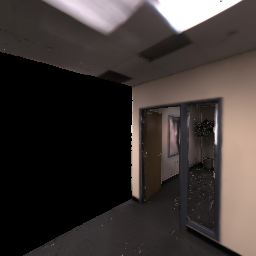

[ 1.3072395 -1.6002482  4.365981 ]
^C


IndexError: ignored

In [ ]:
sim = configure_simulation(room="apartment", agentHeight=1.72, moveAmount=1.4, turnAmount=10.0)
positions = beginRunning(sim)
try:
    sim.close()
except NameError:
    pass

## Dynamic Window

In [ ]:
import math
from enum import Enum

import matplotlib.pyplot as plt
import numpy as np

show_animation = True




def plot_arrow(x, y, yaw, length=0.5, width=0.1):  # pragma: no cover
    plt.arrow(x, y, length * math.cos(yaw), length * math.sin(yaw),
              head_length=width, head_width=width)
    plt.plot(x, y)


def plot_obstacles(obstacles):
    for x,y in obstacles:
        circle = plt.Circle((x, y), 0.7, color="black")
        plt.gcf().gca().add_artist(circle)
        # out_x, out_y = (np.array([x, y]) + np.array([np.cos(yaw), np.sin(yaw)]) * 0.7)
        # plt.plot([x, out_x], [y, out_y], "-k")


def plot_robot(x, y, yaw):  # pragma: no cover
    circle = plt.Circle((x, y), 0.33, color="b")
    plt.gcf().gca().add_artist(circle)
    out_x, out_y = (np.array([x, y]) + np.array([np.cos(yaw), np.sin(yaw)]) * 0.33)
    plt.plot([x, out_x], [y, out_y], "-k")


def load_humans(room="castle"):
    if room == "castle":
        human1 = np.array(PK[:100])
        human2 = np.array(PK[200:300])
        human3 = np.array(PK[400:500])
        human4 = np.array(PK[600:700])
    elif room == "hotel":
        human1 = np.array(Utkash[:100])
        human2 = np.array(Utkash[200:300])
        human3 = np.array(Utkash[400:500])
        human4 = np.array(Utkash[600:700])
    human1 = np.vstack((human1, np.flip(human1, axis=0)))
    human2 = np.vstack((human2, np.flip(human2, axis=0)))
    human3 = np.vstack((human3, np.flip(human2, axis=0)))
    human4 = np.vstack((human4, np.flip(human2, axis=0)))
    return (human1, human2, human3, human4)


def load_obstacles(humans, time_step, numT):
    ob = None
    for human in humans:
        pos1 = human[(time_step // numT) % numT]
        pos2 = human[((time_step // numT) + 1) % numT]
        if ob is None: ob = np.linspace(pos1, pos2, num=numT)[time_step % numT]
        else: ob = np.vstack((ob, np.linspace(pos1, pos2, num=numT)[time_step % numT]))
    return np.delete(ob, 1, 1)


def hasCollided(x, obstacles):
    obst_sum = np.sum((x - obstacles)**2, axis=1)
    if np.any(((0.33 - 0.7)**2 <= obst_sum) & ((obst_sum <= (0.33 + 0.7)**2))): return True
    # for obstacle in obstacles:
    #     obst_sum = np.sum((x - obstacle)**2, axis=1)
    #     if (0.33 - 0.7)**2 <= obst_sum and (obst_sum <= (0.33 + 0.7)**2): return True
    return False

Finding goal_pos:  [6.3640614 8.366385 ]
Time start:  0
min_x: -5.0
min_y: 16.0
max_x: 6.0
max_y: 19.0
x_width: 6
y_width: 2
2
Start is: -6.4560237 6.3509064
{603.0: <__main__.AStarPlanner.Node object at 0x7f4ad877d320>}
a 94.0 106.0 100.0 108.0
95.0 100.0
94.0 101.0
93.0 100.0
94.0 99.0
93.0 99.0
93.0 101.0
95.0 99.0
95.0 101.0
a 95.0 106.0 101.0 108.0
96.0 101.0
95.0 102.0
94.0 101.0
95.0 100.0
94.0 100.0
in closed
94.0 102.0
96.0 100.0
96.0 102.0
a 96.0 106.0 102.0 108.0
97.0 102.0
96.0 103.0
95.0 102.0
96.0 101.0
95.0 101.0
in closed
95.0 103.0
97.0 101.0
97.0 103.0
a 97.0 106.0 103.0 108.0
98.0 103.0
97.0 104.0
96.0 103.0
97.0 102.0
96.0 102.0
in closed
96.0 104.0
98.0 102.0
98.0 104.0
a 98.0 106.0 104.0 108.0
99.0 104.0
98.0 105.0
97.0 104.0
98.0 103.0
97.0 103.0
in closed
97.0 105.0
99.0 103.0
99.0 105.0
a 95.0 106.0 100.0 108.0
96.0 100.0
95.0 101.0
in closed
94.0 100.0
in closed
95.0 99.0
94.0 99.0
94.0 101.0
96.0 99.0
96.0 101.0
a 96.0 106.0 101.0 108.0
97.0 101.0
96.0 102.0


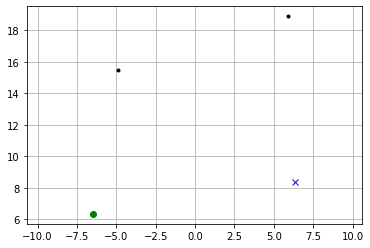

In [ ]:
#room = "castle"
#if room == "castle":
#    start_pos = np.array([-6.4560237,  0.0099186,  6.3509064])
#    goals = np.array([[6.3640614,  0.20991862, 8.366385  ],
#        [-3.2659068,   0.20508613, 19.700174  ],
#        [-0.47940367,  0.20991862, 15.373854  ],
#        [-7.109163,    0.35362667, 22.990005  ],
#        [-0.5511527,   0.00991862,  6.142468  ]])
# elif room == "test":
#goals = np.vstack((goals, start_pos))

#start_pos = np.delete(start_pos, 1)
#goals = np.delete(goals, 1, 1)

x = np.append(start_pos, np.array([np.pi / 8, 0, 0]))

humans = load_humans()

# dt = 1 / 60 # default
numT = 5
dt = 1 / numT
time_step = 0

# Human, Stationary
collisionCounts = [0, 0]
# Total distance traveled
totalDistance = 0
grid_size = 2.0  # [m]
robot_radius = 0.165  # [m]
# Entire path taken
totalTrajectory = None
show_animation = True
while len(goals) > 0:
    trajectory = np.array(x)
    goal_pos = goals[0]
    goals = np.delete(goals, 0, 0)
    print("============================================")
    print("Finding goal_pos: ", goal_pos)
    print("Time start: ", time_step)
    while True:
        ob = load_obstacles(humans, time_step, numT)
        if hasCollided(x[:2], ob):
            collisionCounts[0] += 1
        # u, predicted_trajectory = dwa_control(x, goal_pos, ob, dt)
        ox = [ob[0][0],ob[1][0]]
        oy = [ob[0][1],ob[1][1]]
        a_star = AStarPlanner(ox,oy, grid_size, robot_radius)
        print("Start is:", x[0], x[1] )
        # print(x[0], x[1], goal_pos[0], goal_pos[1],ox,oy)
        rx, ry = a_star.planning(x[0], x[2], goal_pos[0], goal_pos[1])
        print(rx,ry)

      
        if show_animation:  # pragma: no cover
          plt.plot(ox, oy, ".k")
          plt.plot(x[0], x[1], "og")
          plt.plot(goal_pos[0], goal_pos[1], "xb")
          plt.grid(True)
          plt.axis("equal")
        
        goals = []
        break

        # if show_animation:
        #     plt.clf()
        #     # for stopping simulation with the esc key.
        #     # plt.gcf().canvas.mpl_connect('key_release_event', lambda event: [exit(0) if event.key == 'escape' else None])
        #     plt.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], "-g")
        #     plt.plot(x[0], x[1], "xr")
        #     plt.plot(goal_pos[0], goal_pos[1], "xb")
        #     # plt.plot(ob[:, 0], ob[:, 1], "or", markersize=0.7)
        #     plot_obstacles(ob)
        #     plot_robot(x[0], x[1], x[2])
        #     plot_arrow(x[0], x[1], x[2])
        #     plt.axis("equal")
        #     # plt.grid(True)
        #     plt.pause(0.0001)
        # check reaching goal
        dist_to_goal = math.hypot(x[0] - goal_pos[0], x[1] - goal_pos[1])
        # print("dist_to_goal", dist_to_goal)
        # if dist_to_goal <= sim.robot_radius:
        if dist_to_goal <= 0.33:
            print("Goal!!")
            break
        time_step += 1
    if totalTrajectory is None:
        totalTrajectory = trajectory
    else:
        totalTrajectory = np.vstack((totalTrajectory, trajectory))
    print("Found goal_pos")
    print("Collision Count: ", collisionCounts)
    print("Time lap: ", time_step)
    print("Distance traveled: ", totalDistance)
    print("============================================")
    print("\n")

print("Done")
print("Collision Count: ", collisionCounts)
print("Time taken: ", time_step)
print("Distance traveled: ", totalDistance)

In [ ]:
if show_animation:
    for trajectory in totalTrajectory:
        plt.plot(trajectory[:, 0], trajectory[:, 1], "-r")
        plt.pause(0.0001)
    plt.show()

In [ ]:
totalTrajectory.shape

(654, 5)


# A*


In [ ]:
class AStarPlanner:

    def __init__(self, ox, oy, resolution, rr):
        """
        Initialize grid map for a star planning
        ox: x position list of Obstacles [m]
        oy: y position list of Obstacles [m]
        resolution: grid resolution [m]
        rr: robot radius[m]
        """

        self.resolution = resolution
        self.rr = rr
        self.min_x, self.min_y = 0, 0
        self.max_x, self.max_y = 0, 0
        self.obstacle_map = None
        self.x_width, self.y_width = 0, 0
        self.motion = self.get_motion_model()
        self.calc_obstacle_map(ox, oy)

    class Node:
        def __init__(self, x, y, cost, parent_index):
            self.x = x  # index of grid
            self.y = y  # index of grid
            self.cost = cost
            self.parent_index = parent_index

        def __str__(self):
            return str(self.x) + "," + str(self.y) + "," + str(
                self.cost) + "," + str(self.parent_index)

    def planning(self, sx, sy, gx, gy):
        """
        A star path search
        input:
            s_x: start x position [m]
            s_y: start y position [m]
            gx: goal x position [m]
            gy: goal y position [m]
        output:
            rx: x position list of the final path
            ry: y position list of the final path
        """

        start_node = self.Node(self.calc_xy_index(sx, self.min_x),
                               self.calc_xy_index(sy, self.min_y), 0.0, -1)
        goal_node = self.Node(self.calc_xy_index(gx, self.min_x),
                              self.calc_xy_index(gy, self.min_y), 0.0, -1)

        open_set, closed_set = dict(), dict()
        open_set[self.calc_grid_index(start_node)] = start_node
        print(open_set)
        while 1:
            if len(open_set) == 0:
                print("Open set is empty..")
                break

            c_id = min(
                open_set,
                key=lambda o: open_set[o].cost + self.calc_heuristic(goal_node,
                                                                     open_set[
                                                                         o]))
            current = open_set[c_id]
            print('a',current.x,goal_node.x, current.y,goal_node.y)

            # show graph
            # if show_animation:  # pragma: no cover
            #     plt.plot(self.calc_grid_position(current.x, self.min_x),
            #              self.calc_grid_position(current.y, self.min_y), "xc")
            #     # for stopping simulation with the esc key.
            #     plt.gcf().canvas.mpl_connect('key_release_event',
            #                                  lambda event: [exit(
            #                                      0) if event.key == 'escape' else None])
            #     if len(closed_set.keys()) % 10 == 0:
            #         plt.pause(0.001)

            if current.x == goal_node.x and current.y == goal_node.y:
                
                print("Find goal")
                goal_node.parent_index = current.parent_index
                goal_node.cost = current.cost
                break

            # Remove the item from the open set
            del open_set[c_id]

            # Add it to the closed set
            closed_set[c_id] = current

            # expand_grid search grid based on motion model
            for i, _ in enumerate(self.motion):
                node = self.Node(current.x + self.motion[i][0],
                                 current.y + self.motion[i][1],
                                 current.cost + self.motion[i][2], c_id)
                n_id = self.calc_grid_index(node)

                # If the node is not safe, do nothing
                if not self.verify_node(node):
                    print('not safe')
                    continue

                if n_id in closed_set:
                    print('in closed')
                    continue

                if n_id not in open_set:
                    open_set[n_id] = node  # discovered a new node
                else:
                    if open_set[n_id].cost > node.cost:
                        # This path is the best until now. record it
                        open_set[n_id] = node

        print('c',closed_set)
        rx, ry = self.calc_final_path(goal_node, closed_set)

        return rx, ry

    def calc_final_path(self, goal_node, closed_set):
        # generate final course
        rx, ry = [self.calc_grid_position(goal_node.x, self.min_x)], [
            self.calc_grid_position(goal_node.y, self.min_y)]
        parent_index = goal_node.parent_index
        print("rx,ry",rx,ry,parent_index)
        while parent_index != -1:
            n = closed_set[parent_index]
            rx.append(self.calc_grid_position(n.x, self.min_x))
            ry.append(self.calc_grid_position(n.y, self.min_y))
            parent_index = n.parent_index

        return rx, ry

    @staticmethod
    def calc_heuristic(n1, n2):
        w = 1.0  # weight of heuristic
        d = w * math.hypot(n1.x - n2.x, n1.y - n2.y)
        return d

    def calc_grid_position(self, index, min_position):
        """
        calc grid position
        :param index:
        :param min_position:
        :return:
        """
        pos = index * self.resolution + min_position
        return pos

    def calc_xy_index(self, position, min_pos):
        return round((position - min_pos) / self.resolution)

    def calc_grid_index(self, node):
        return (node.y - self.min_y) * self.x_width + (node.x - self.min_x)

    def verify_node(self, node):
        # px = self.calc_grid_position(node.x, self.min_x)
        # py = self.calc_grid_position(node.y, self.min_y)

        # if px < self.min_x:
        #     return False
        # elif py < self.min_y:
        #     return False
        # elif px >= self.max_x:
        #     return False
        # elif py >= self.max_y:
        #     return False

        # collision check
        print(node.x,node.y)
        if self.obstacle_map[int(node.x)][int(node.y)]:
            print("collision")
            return False

        return True

    def calc_obstacle_map(self, ox, oy):

        # self.min_x = round(min(ox))
        # self.min_y = round(min(oy))
        # self.max_x = round(max(ox))
        # self.max_y = round(max(oy))

        self.min_x = -100
        self.min_y = -100
        self.max_x = 100
        self.max_y = 100
        print("min_x:", self.min_x)
        print("min_y:", self.min_y)
        print("max_x:", self.max_x)
        print("max_y:", self.max_y)

        self.x_width = int(round((self.max_x - self.min_x) / self.resolution))
        self.y_width = int(round((self.max_y - self.min_y) / self.resolution))
        print("x_width:", self.x_width)
        print("y_width:", self.y_width)

        # obstacle map generation
        print(self.y_width)
        self.obstacle_map = [[False for _ in range(self.y_width)]
                             for _ in range(self.x_width)]
        for ix in range(self.x_width):
            x = self.calc_grid_position(ix, self.min_x)
            for iy in range(self.y_width):
                y = self.calc_grid_position(iy, self.min_y)
                for iox, ioy in zip(ox, oy):
                    d = math.hypot(iox - x, ioy - y)
                    if d <= self.rr:
                        self.obstacle_map[ix][iy] = True
                        break

    @staticmethod
    def get_motion_model():
        # dx, dy, cost
        motion = [[1, 0, 1],
                  [0, 1, 1],
                  [-1, 0, 1],
                  [0, -1, 1],
                  [-1, -1, math.sqrt(2)],
                  [-1, 1, math.sqrt(2)],
                  [1, -1, math.sqrt(2)],
                  [1, 1, math.sqrt(2)]]

        return motion


min_x: -10
min_y: -10
max_x: 60
max_y: 60
x_width: 70
y_width: 70


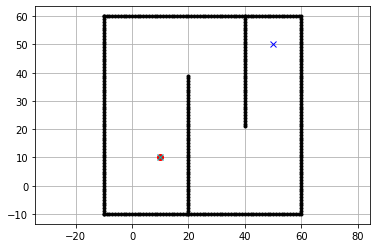

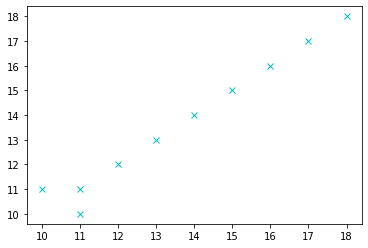

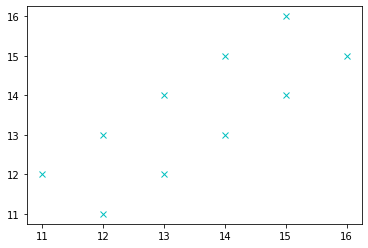

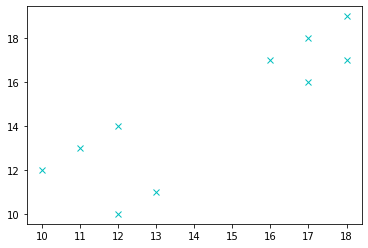

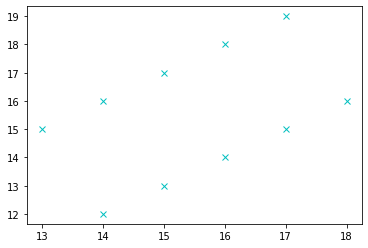

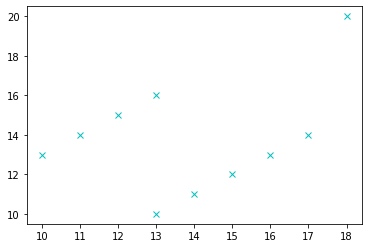

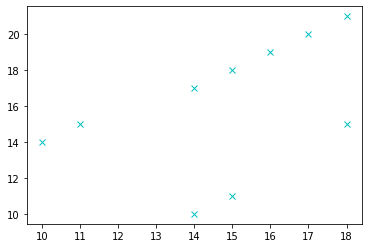

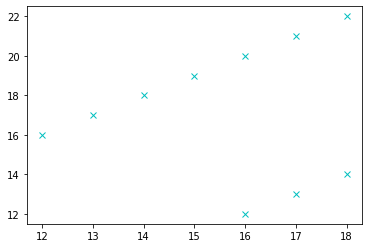

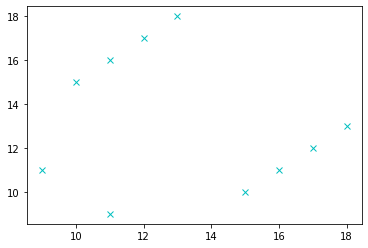

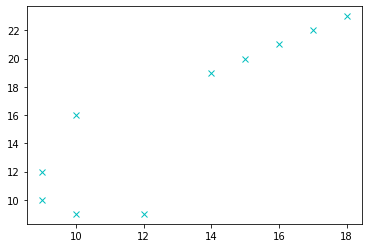

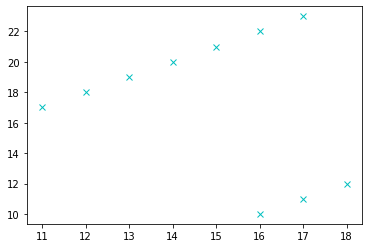

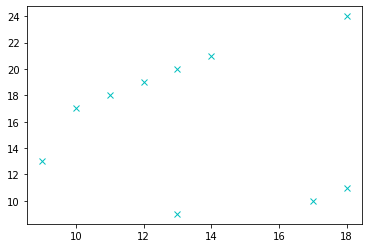

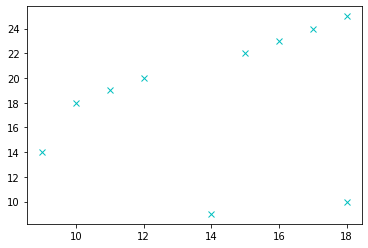

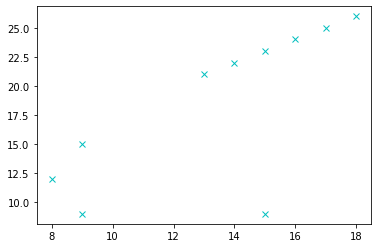

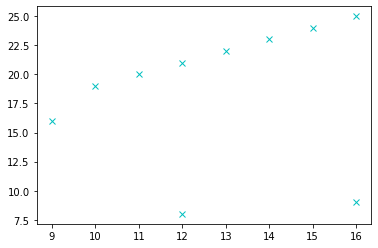

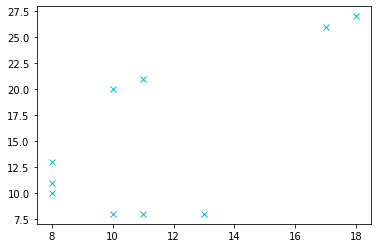

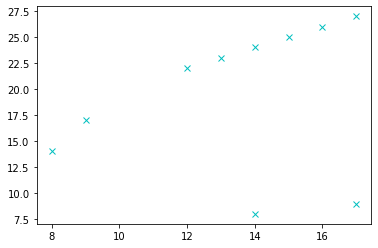

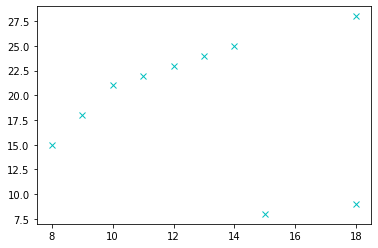

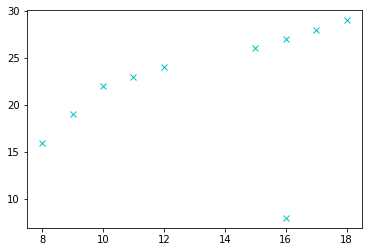

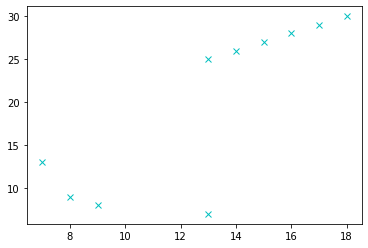

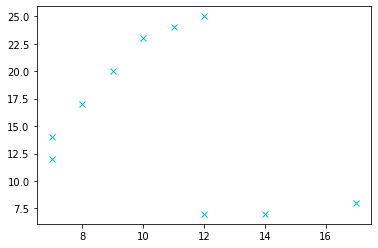

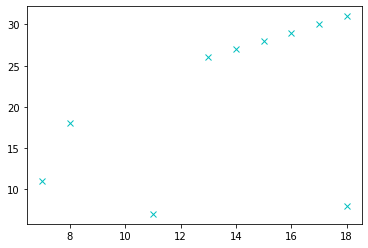

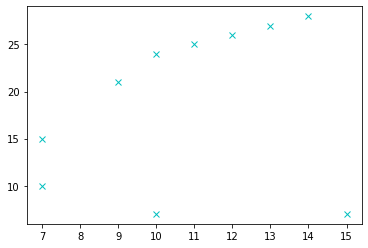

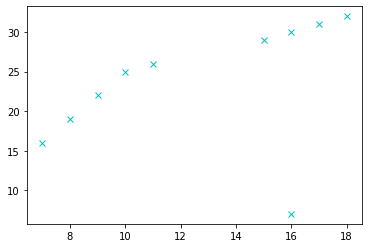

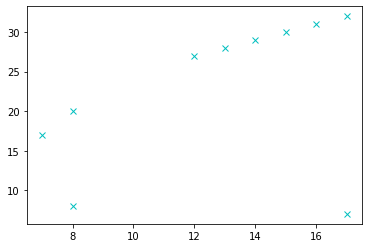

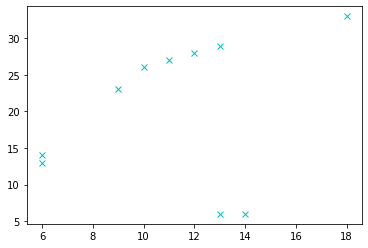

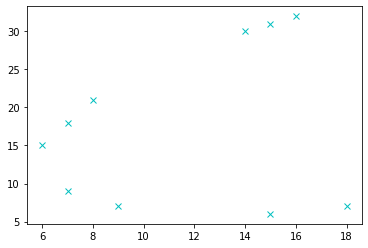

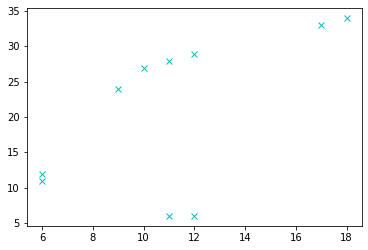

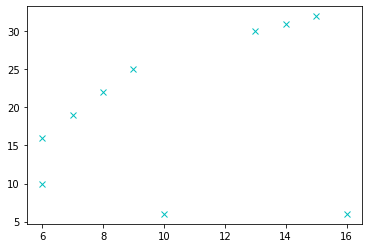

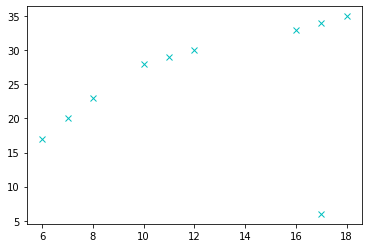

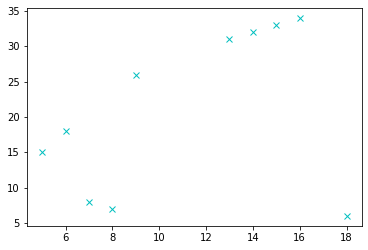

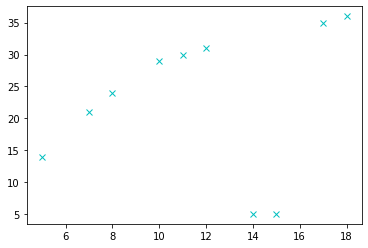

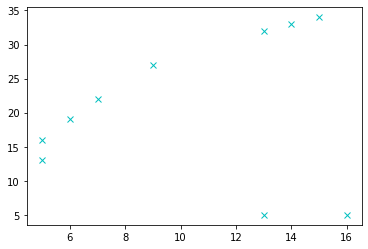

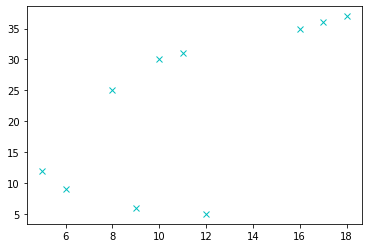

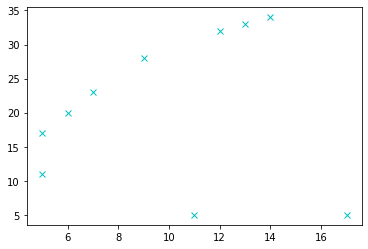

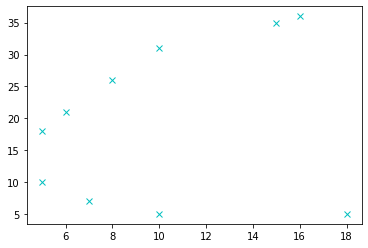

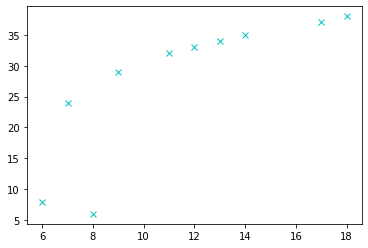

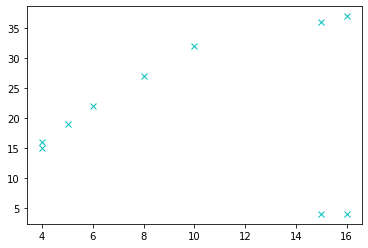

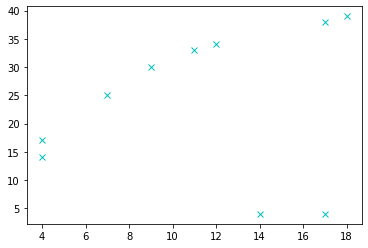

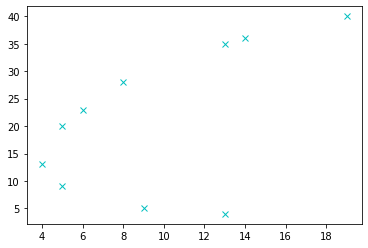

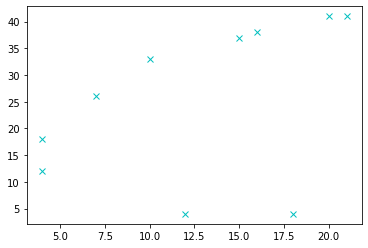

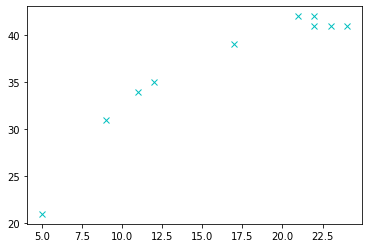

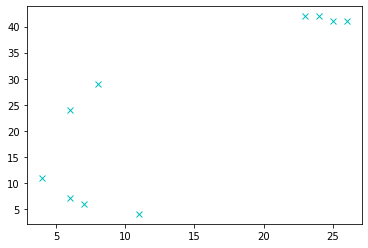

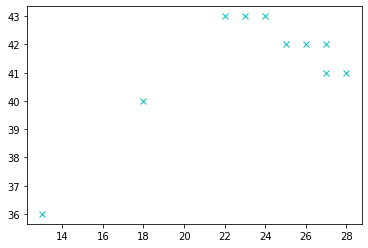

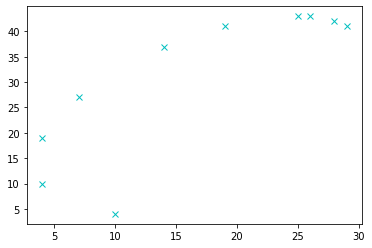

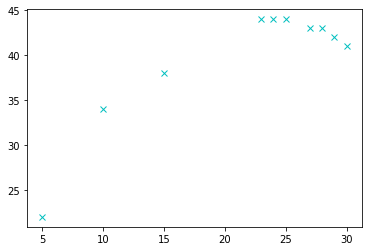

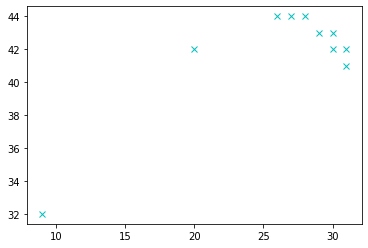

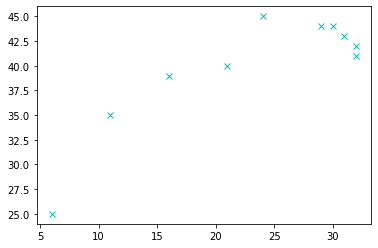

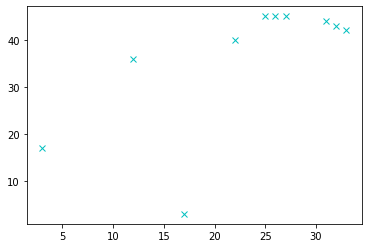

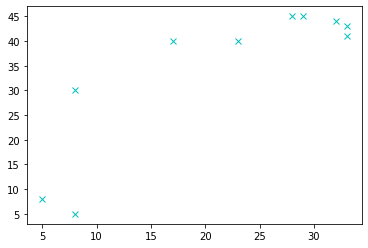

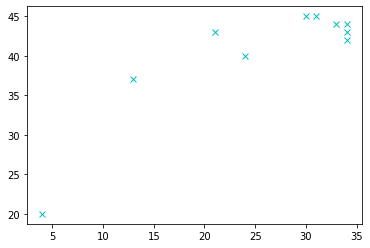

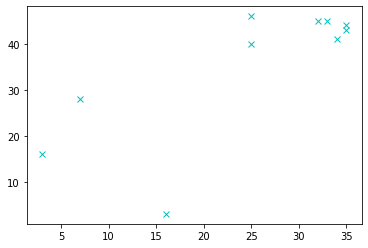

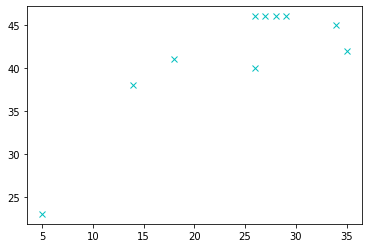

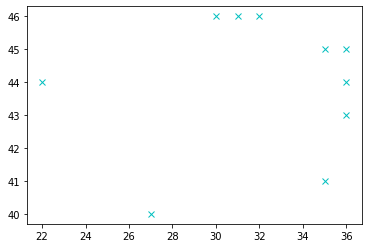

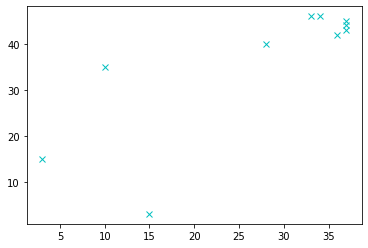

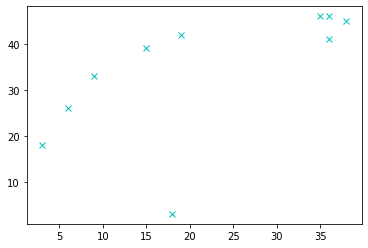

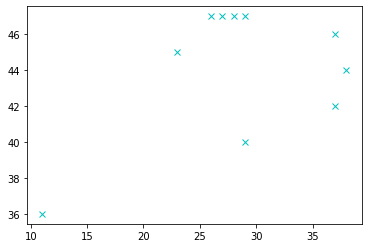

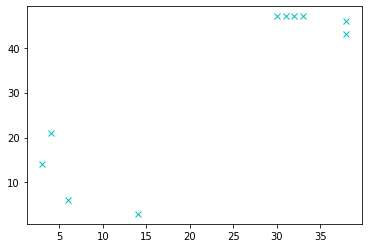

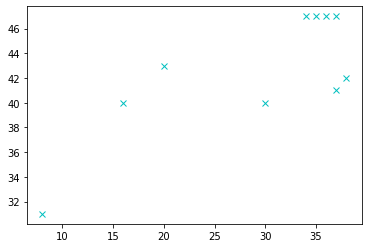

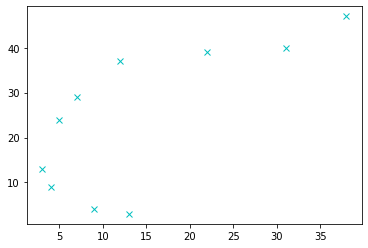

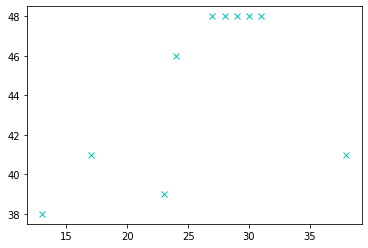

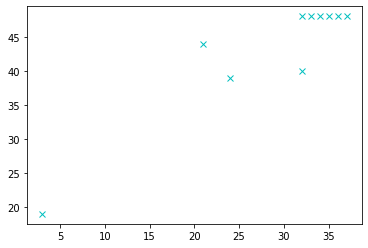

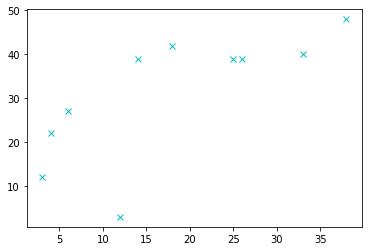

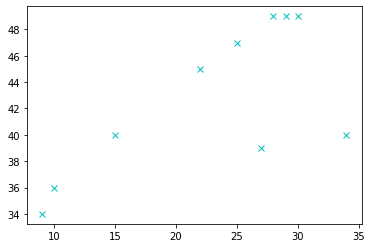

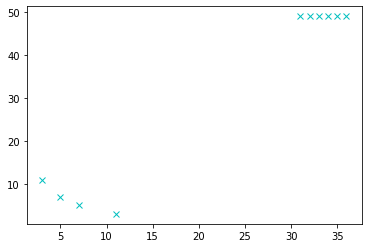

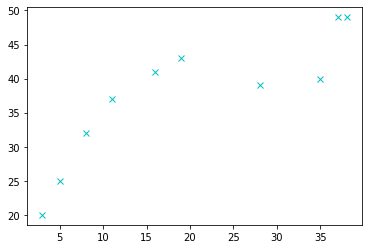

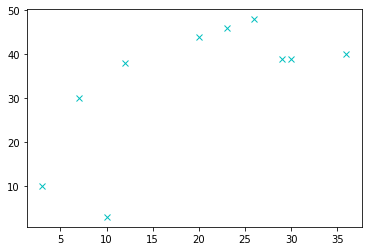

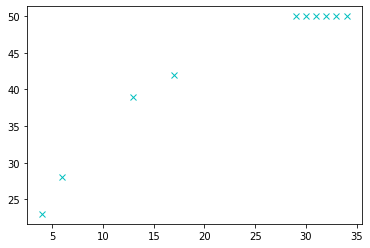

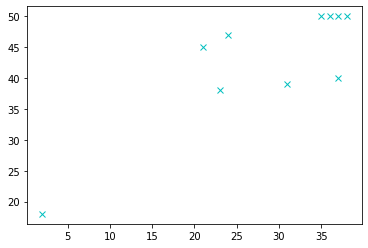

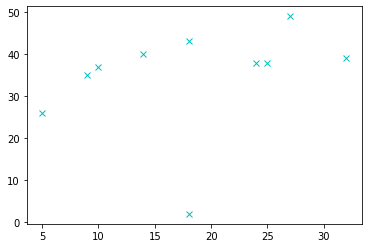

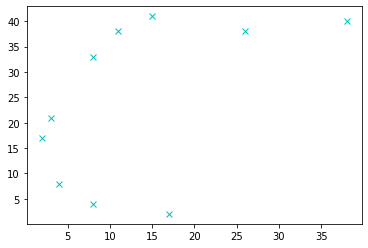

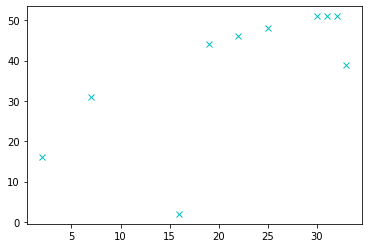

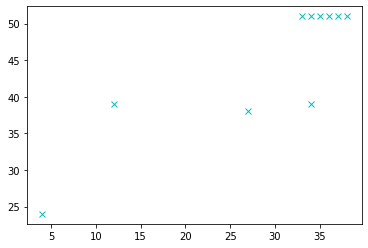

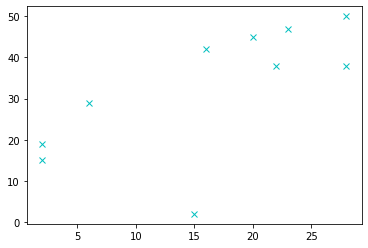

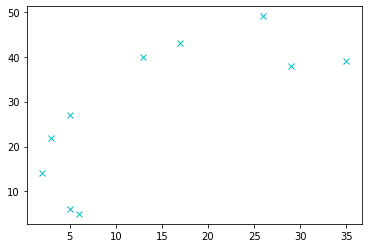

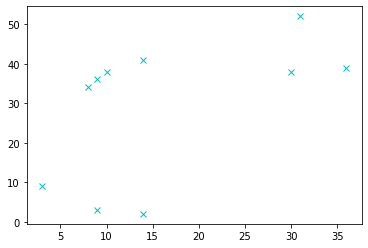

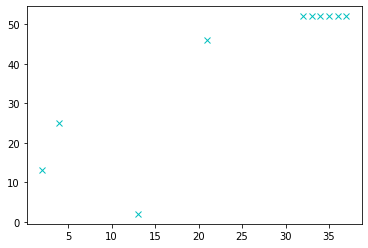

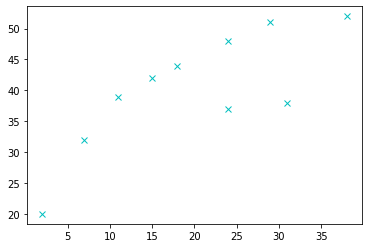

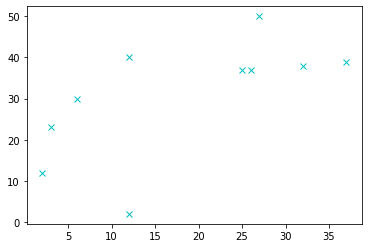

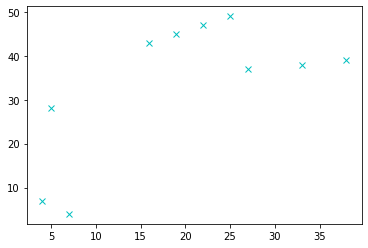

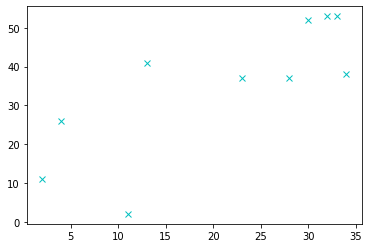

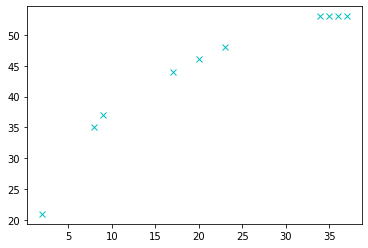

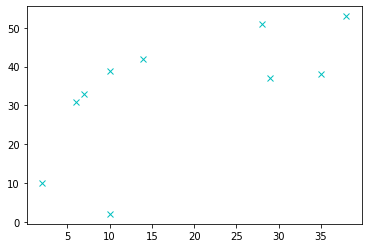

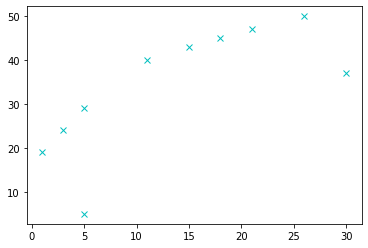

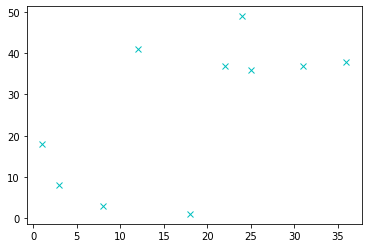

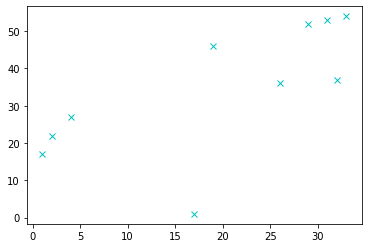

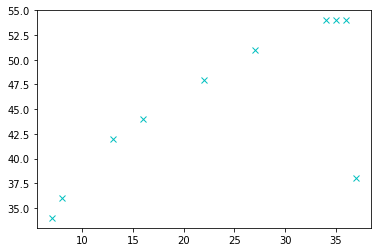

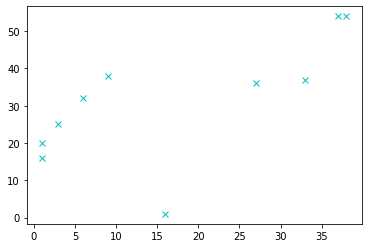

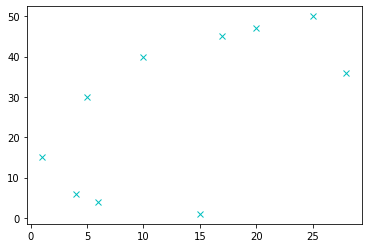

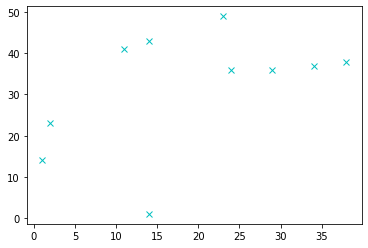

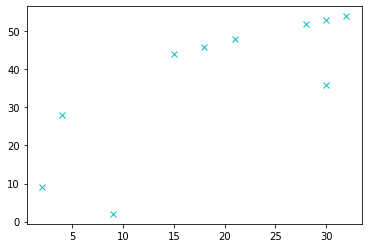

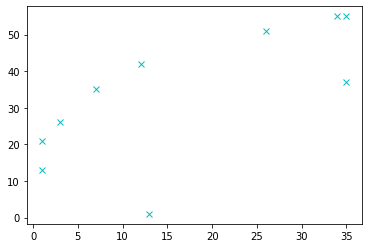

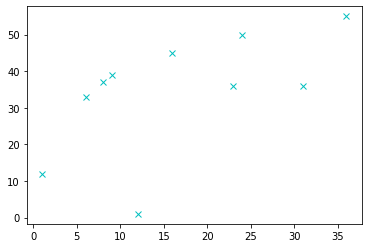

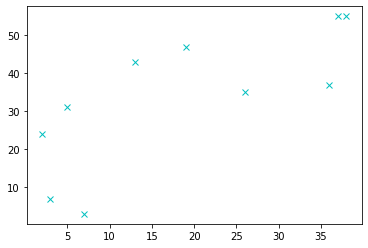

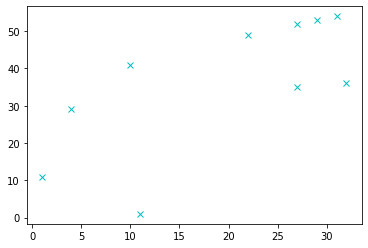

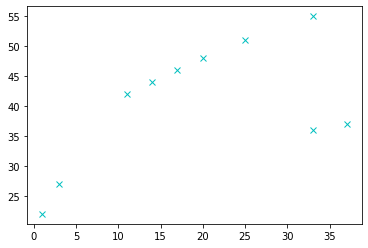

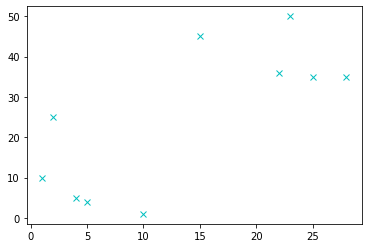

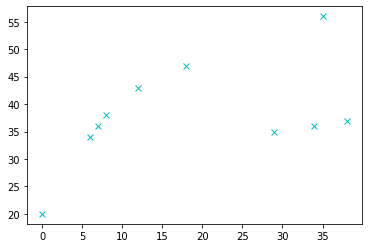

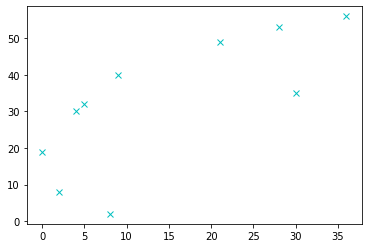

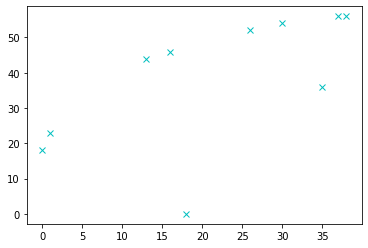

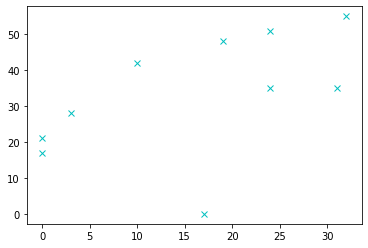

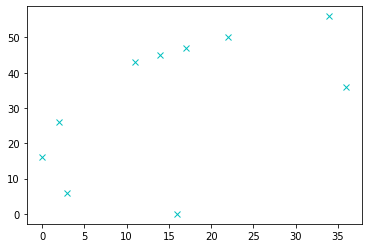

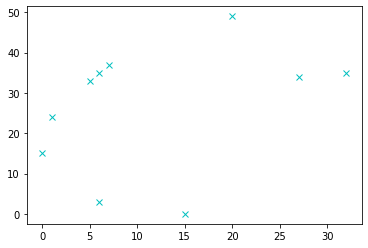

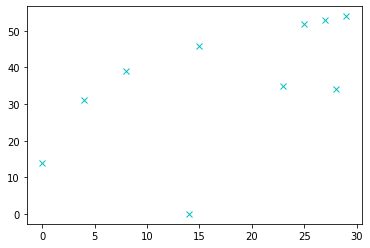

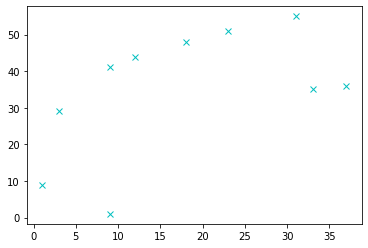

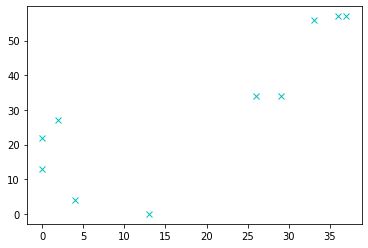

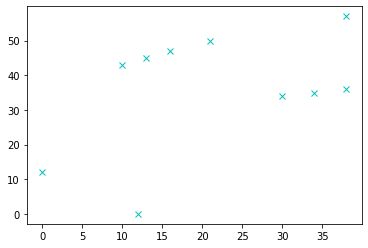

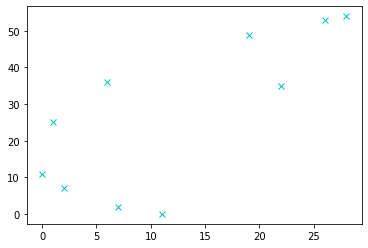

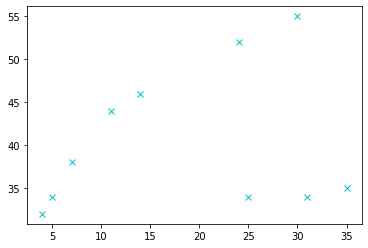

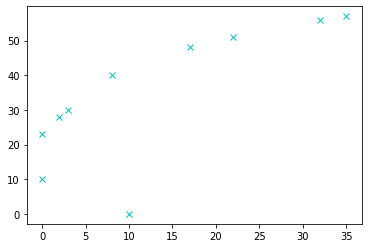

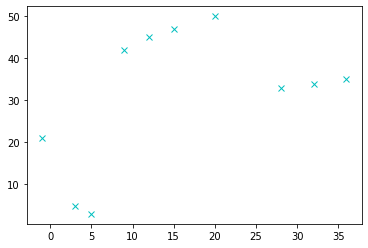

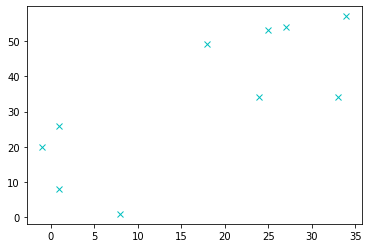

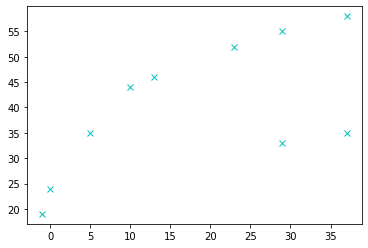

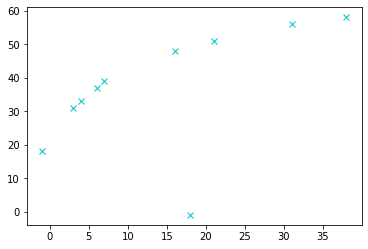

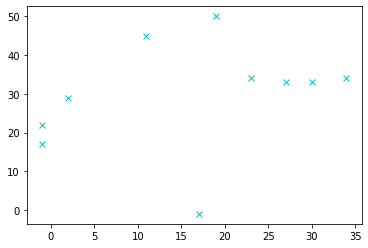

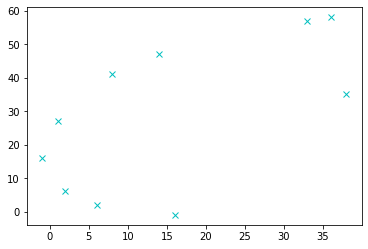

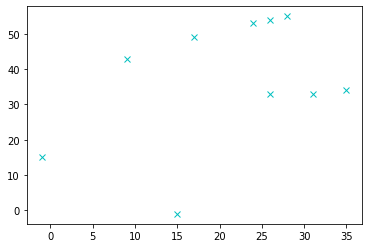

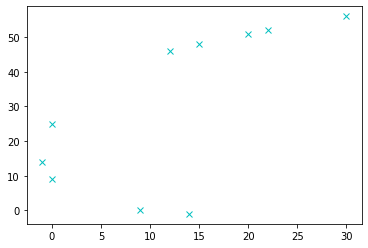

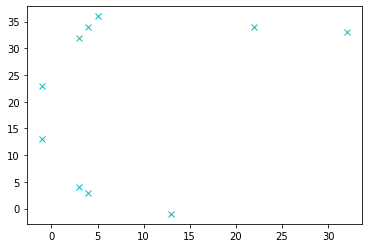

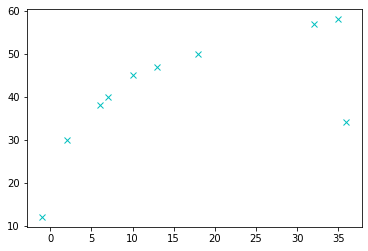

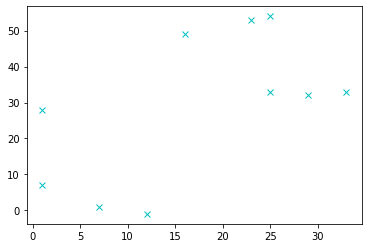

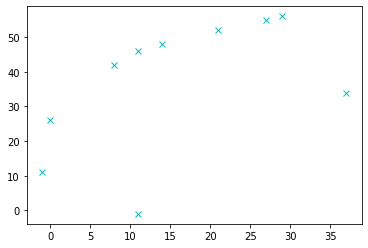

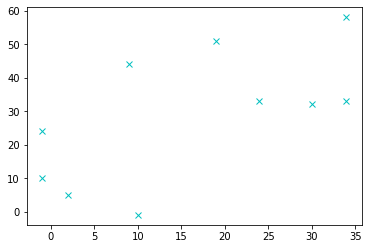

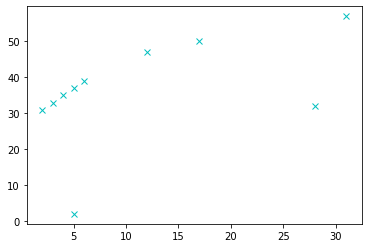

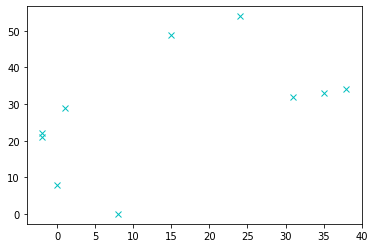

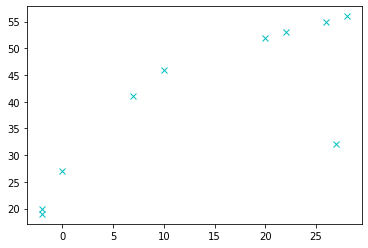

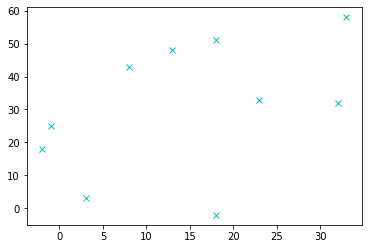

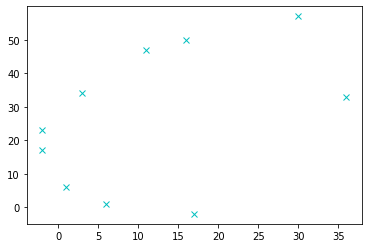

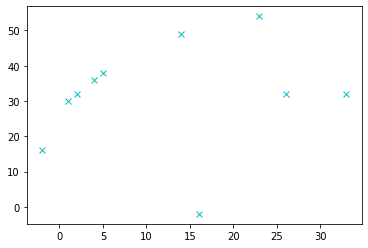

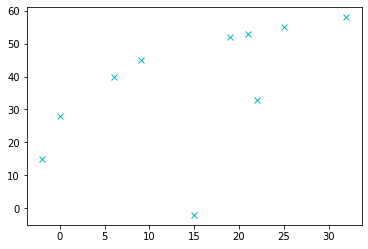

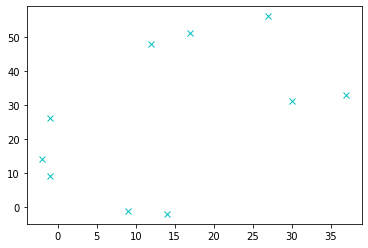

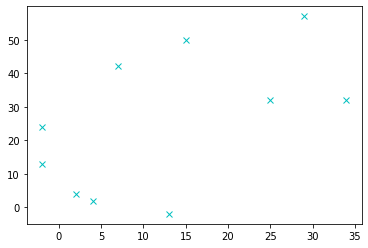

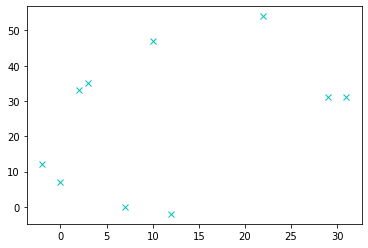

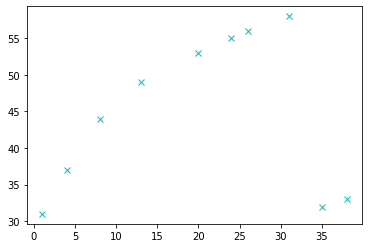

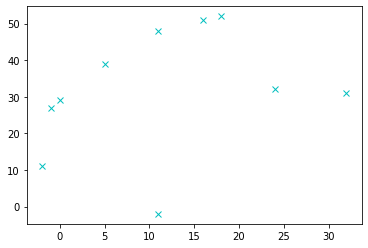

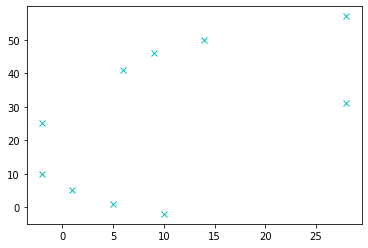

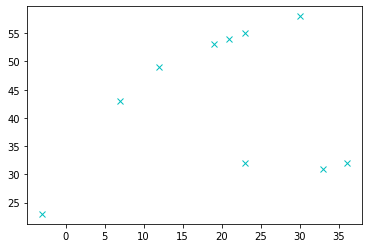

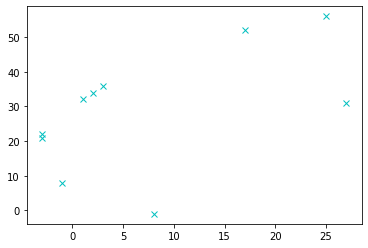

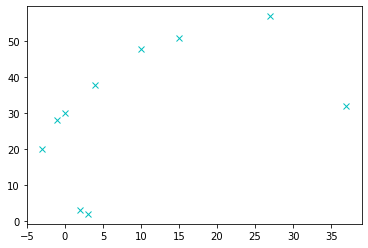

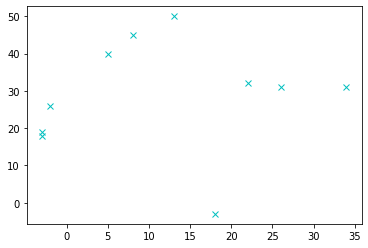

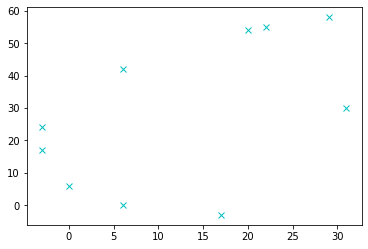

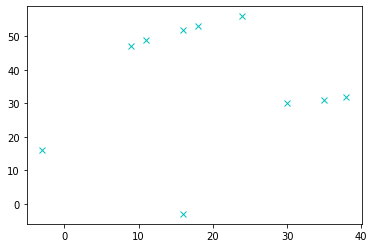

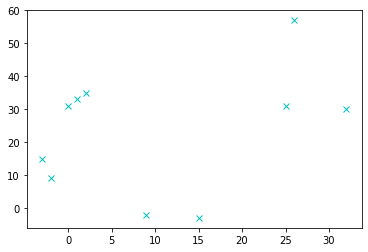

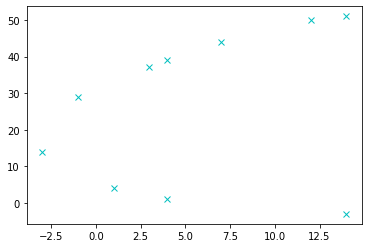

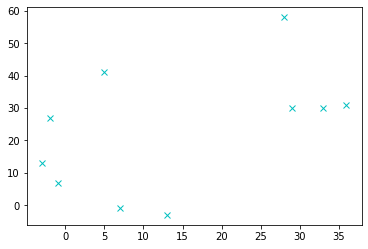

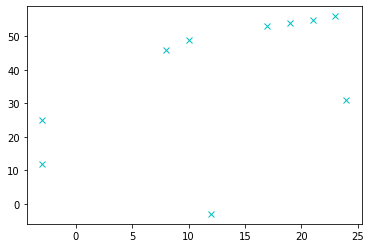

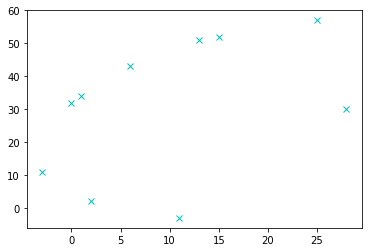

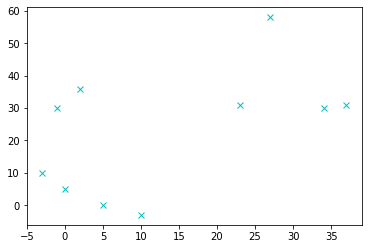

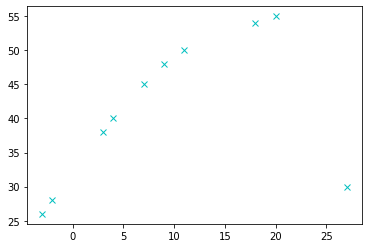

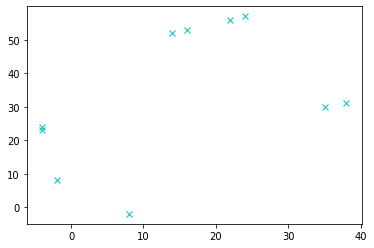

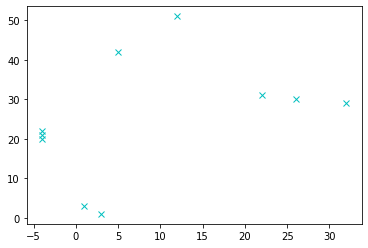

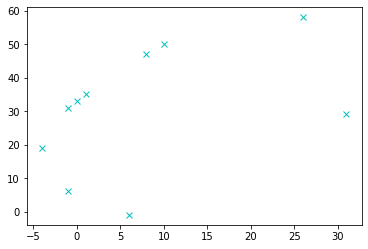

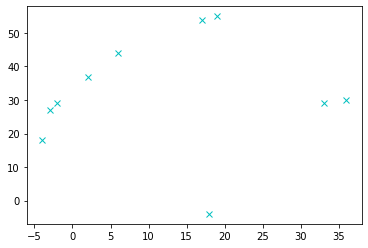

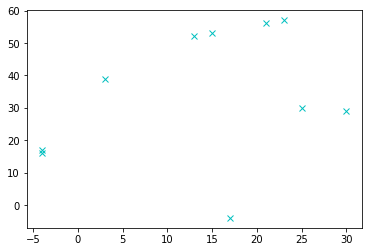

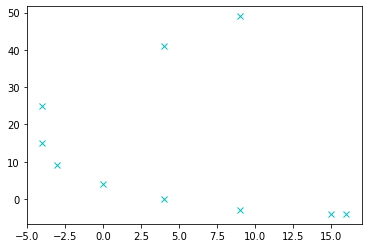

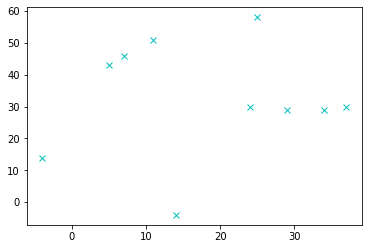

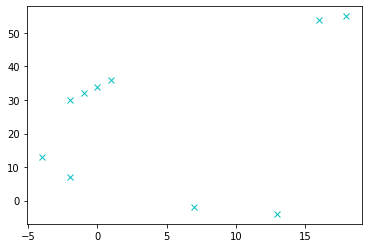

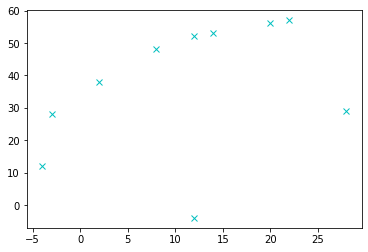

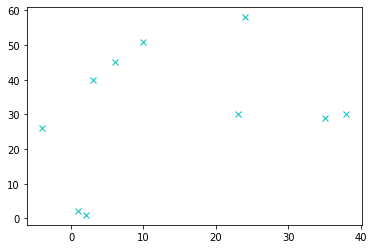

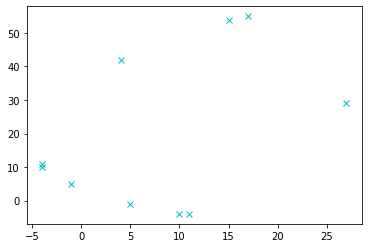

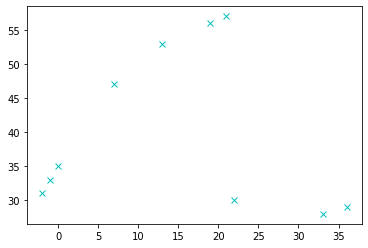

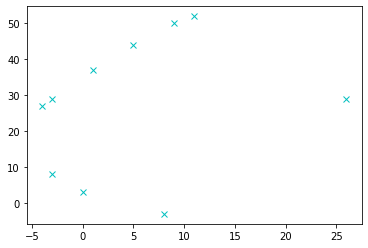

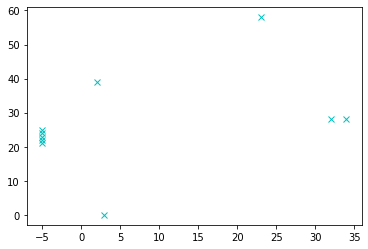

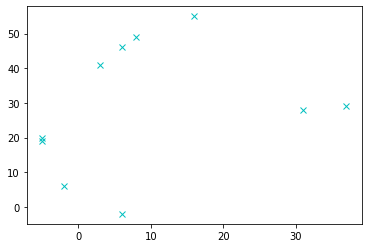

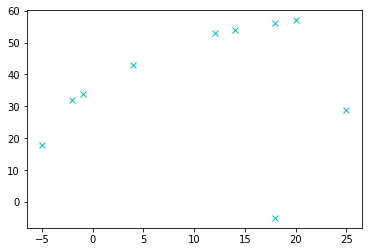

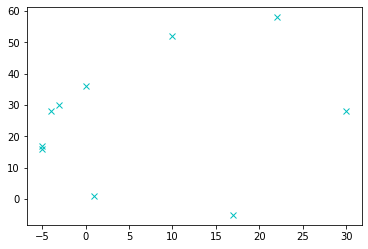

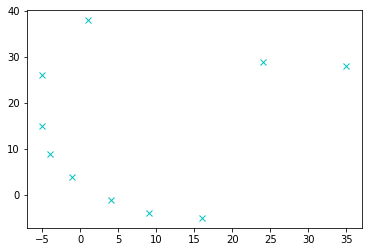

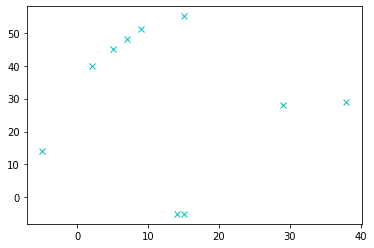

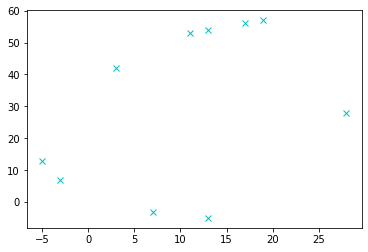

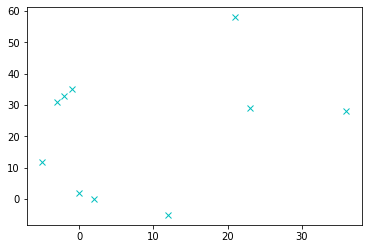

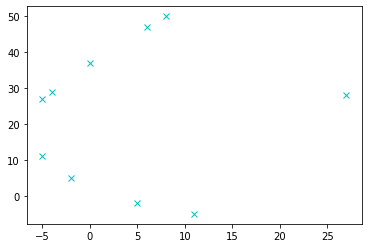

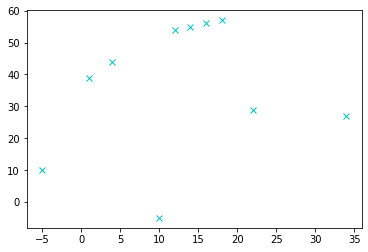

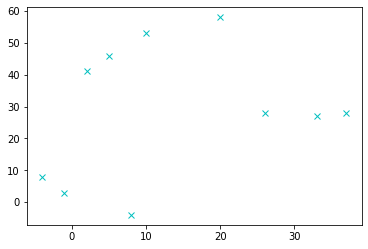

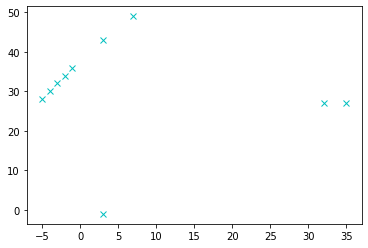

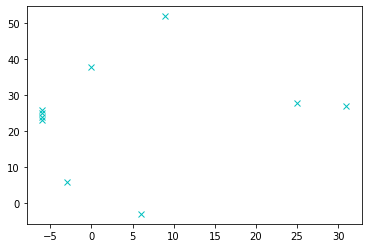

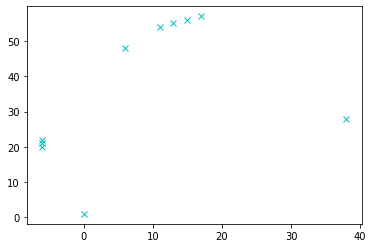

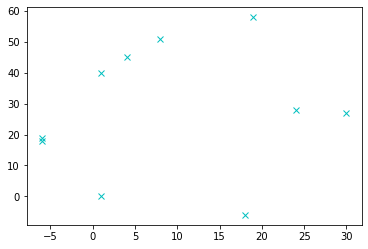

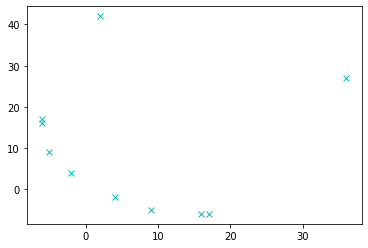

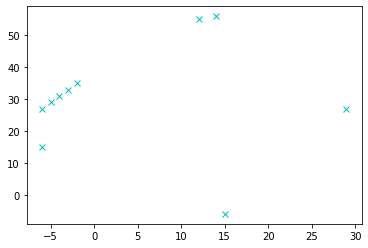

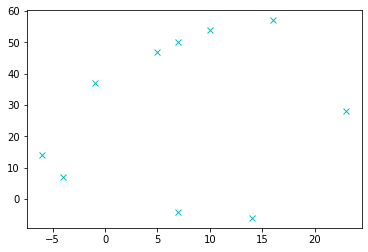

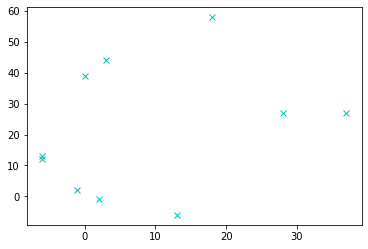

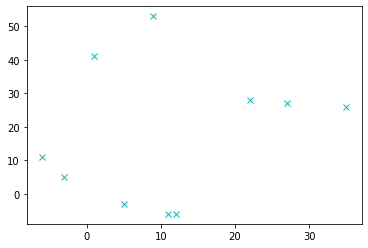

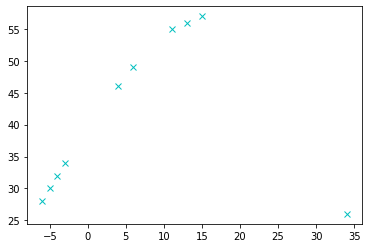

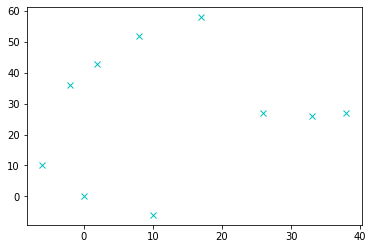

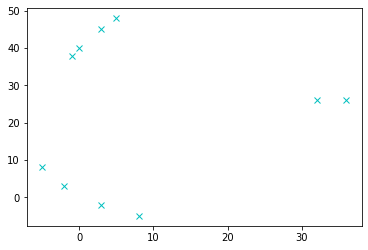

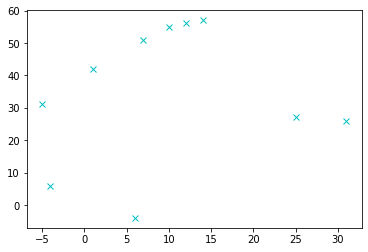

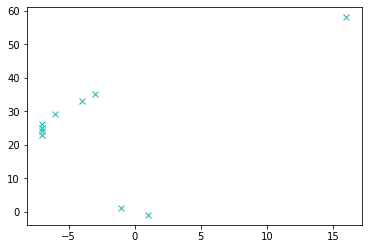

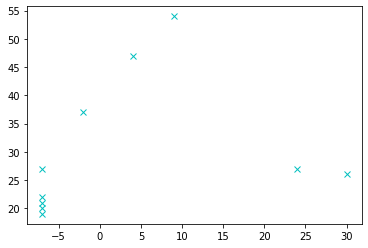

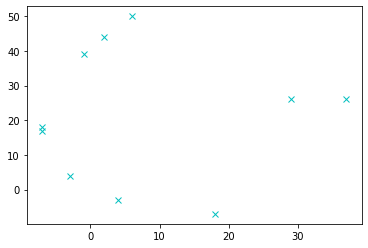

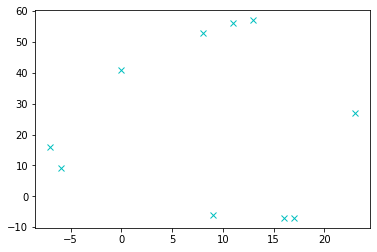

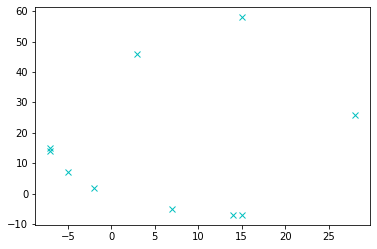

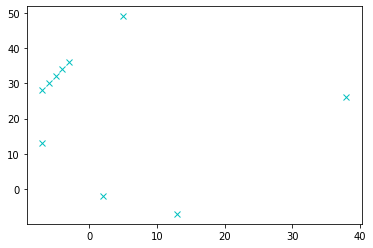

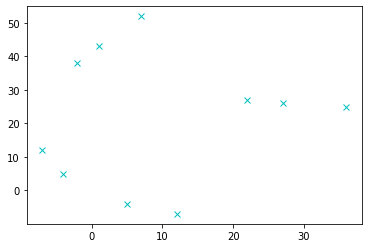

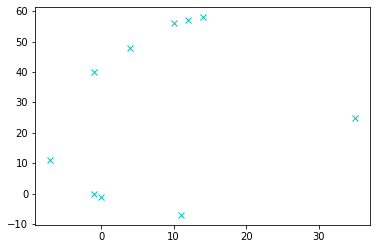

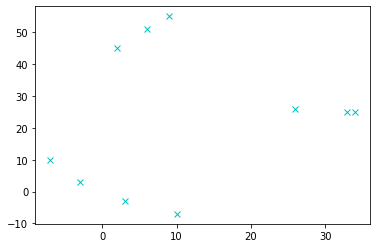

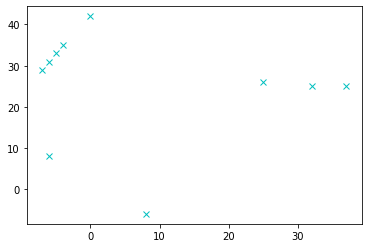

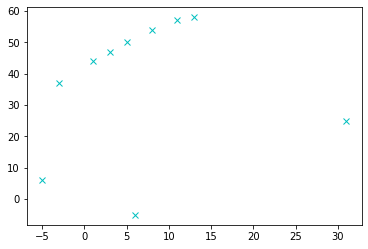

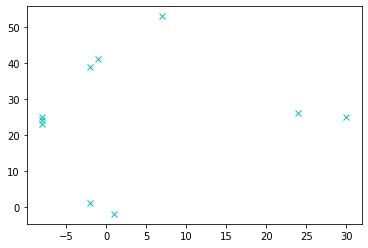

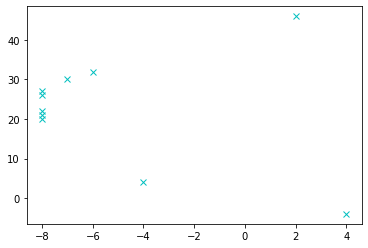

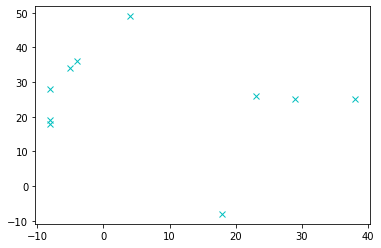

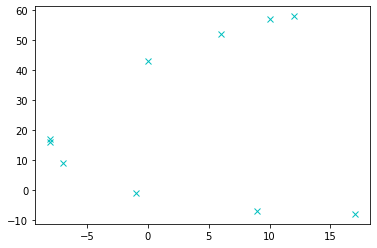

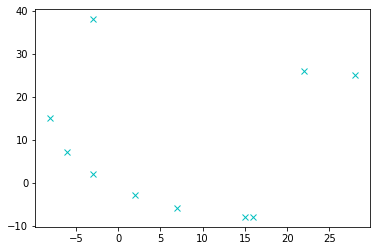

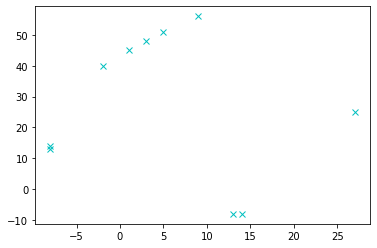

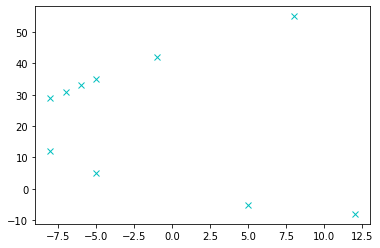

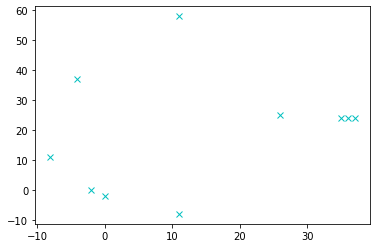

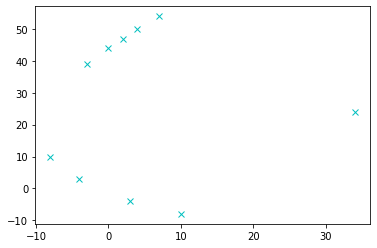

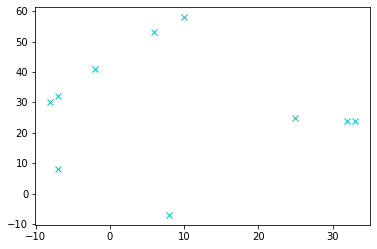

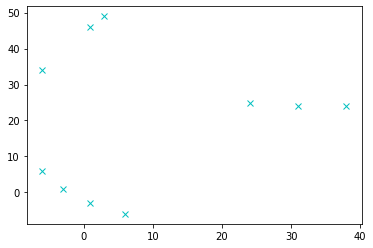

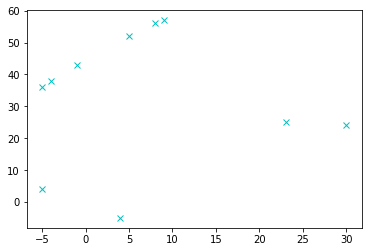

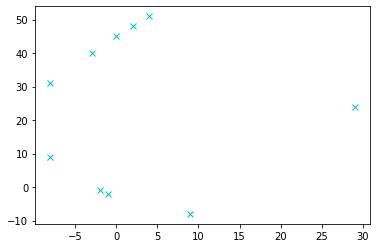

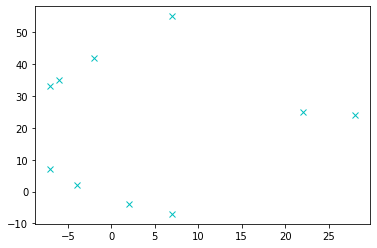

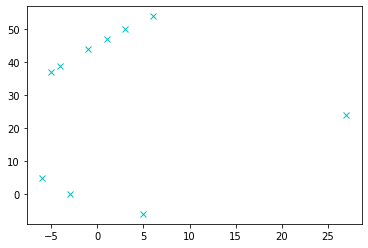

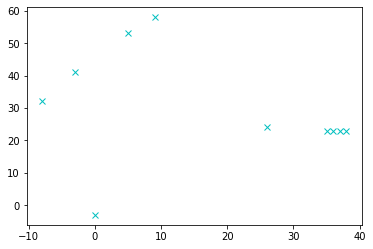

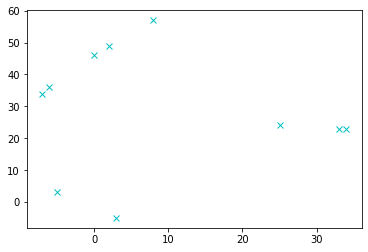

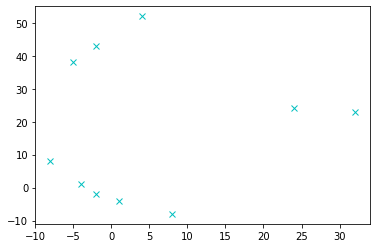

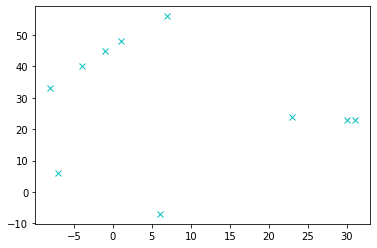

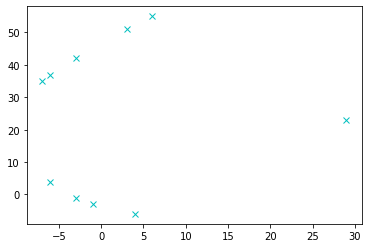

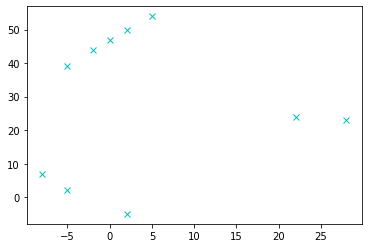

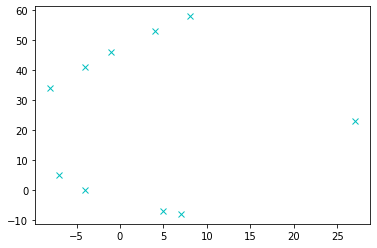

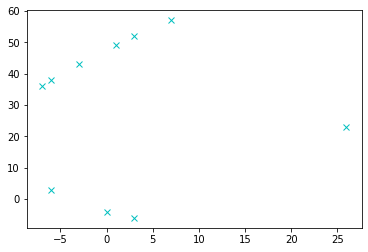

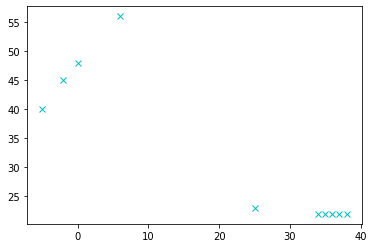

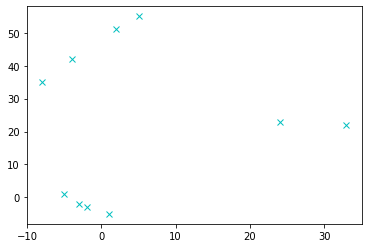

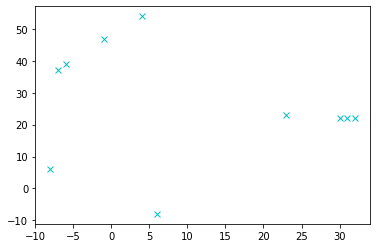

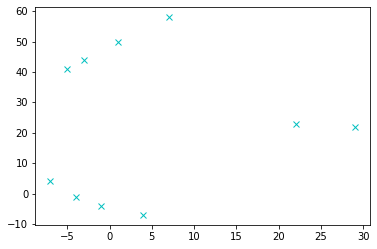

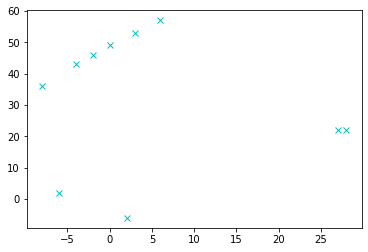

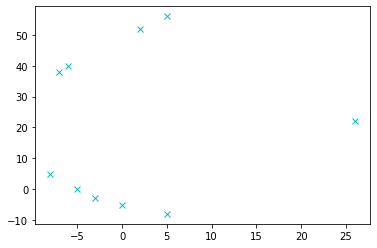

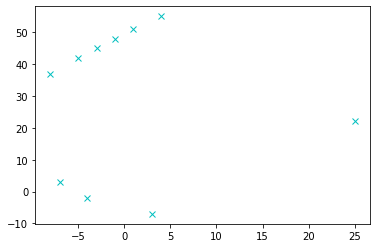

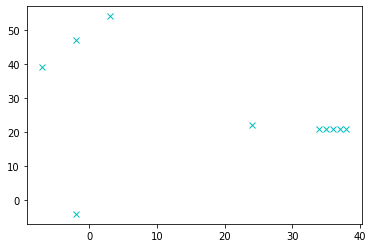

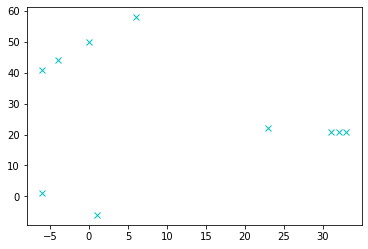

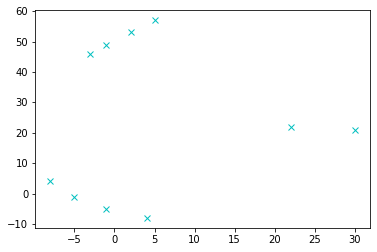

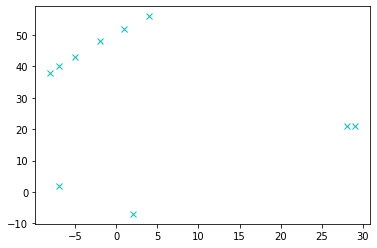

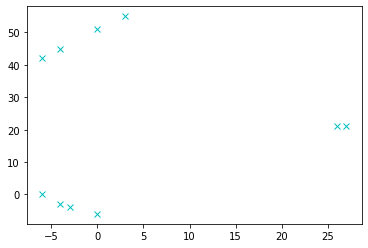

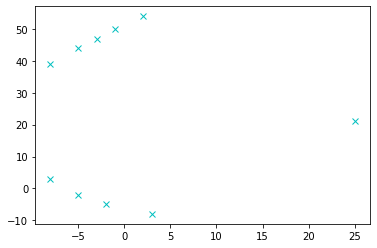

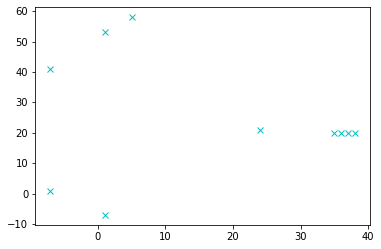

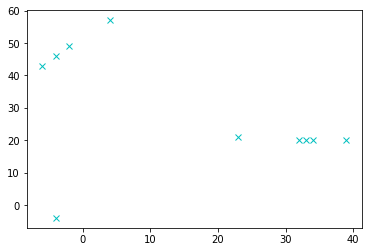

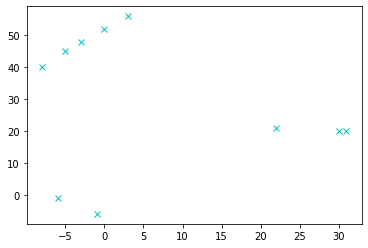

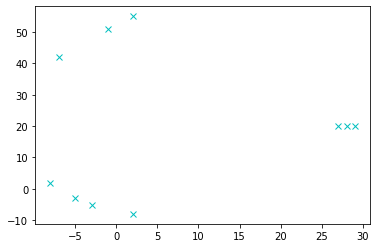

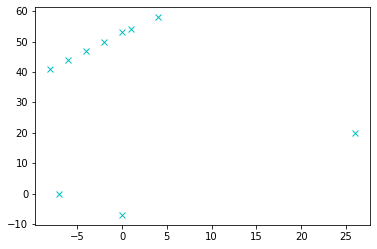

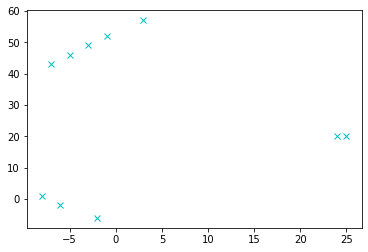

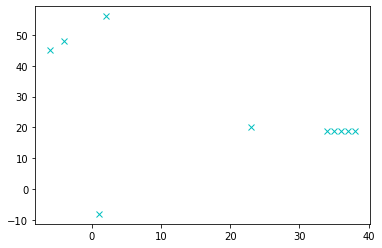

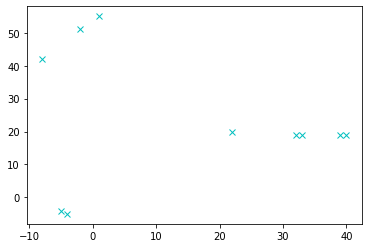

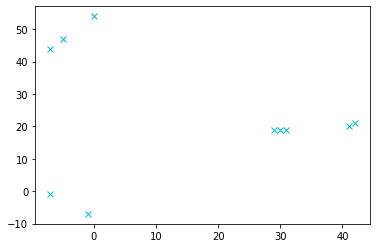

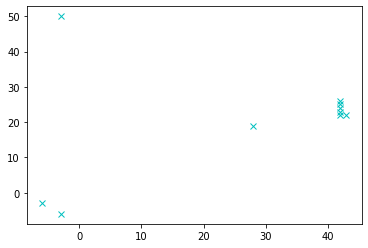

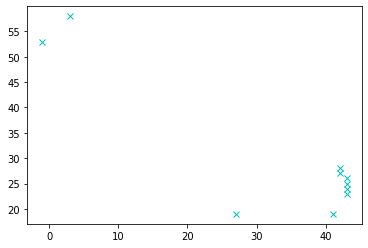

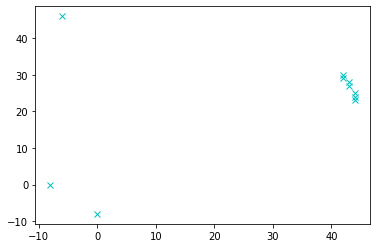

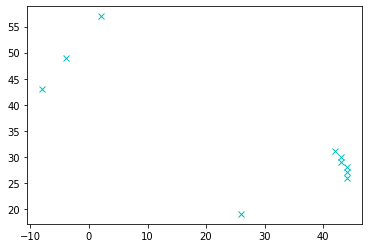

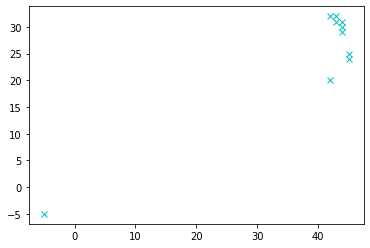

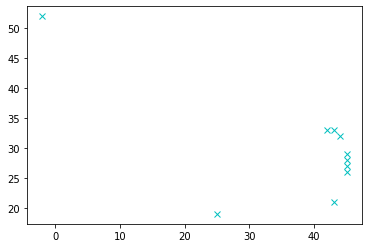

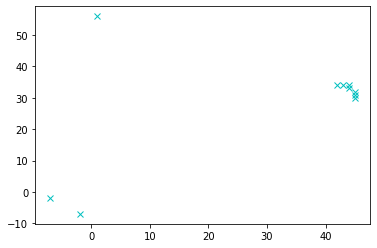

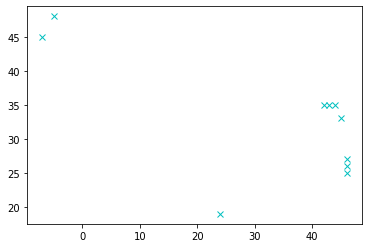

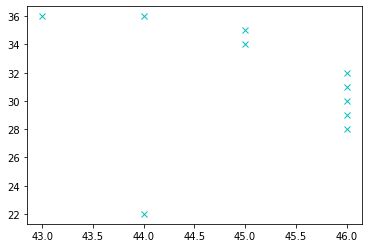

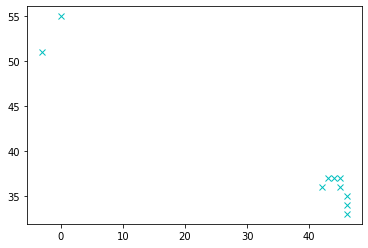

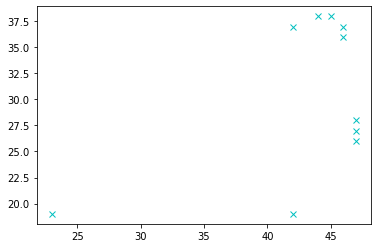

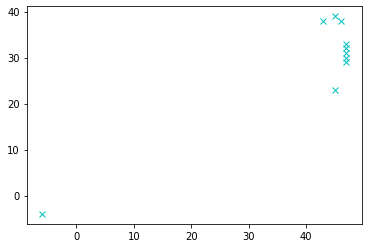

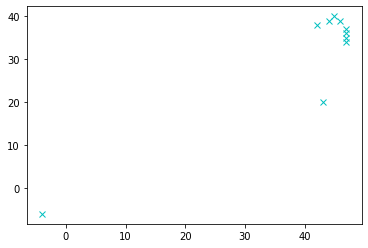

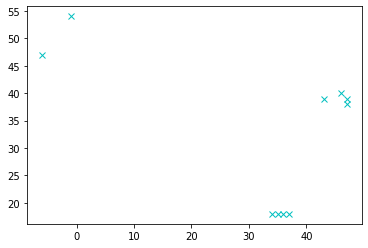

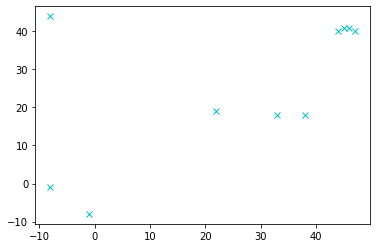

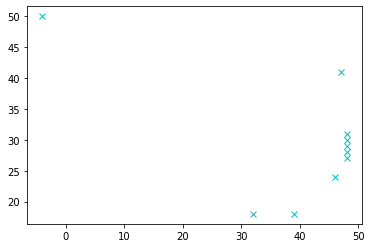

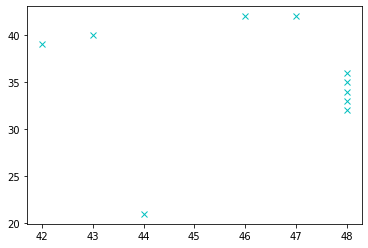

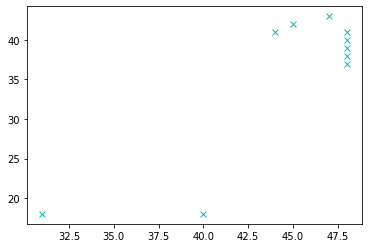

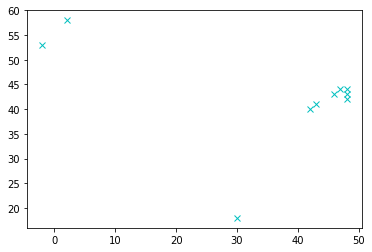

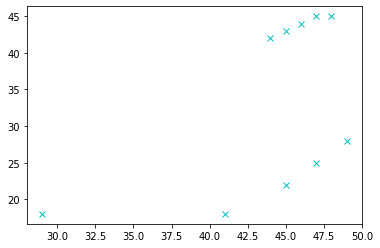

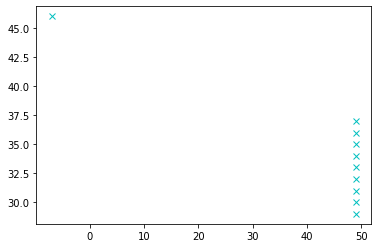

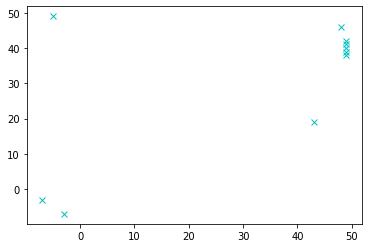

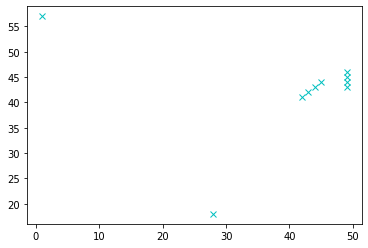

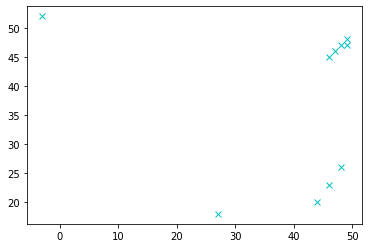

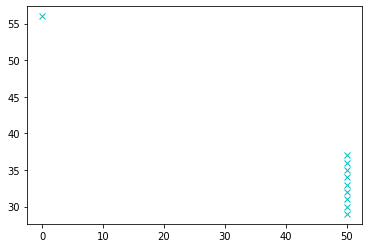

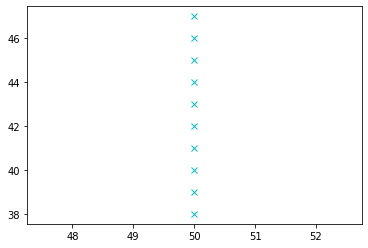

Find goal
[50.0, 49.0, 49.0, 49.0, 48.0, 48.0, 47.0, 47.0, 46.0, 46.0, 45.0, 45.0, 45.0, 44.0, 44.0, 43.0, 43.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 41.0, 40.0, 39.0, 38.0, 37.0, 37.0, 37.0, 36.0, 35.0, 34.0, 33.0, 32.0, 31.0, 30.0, 29.0, 28.0, 27.0, 26.0, 25.0, 24.0, 23.0, 22.0, 21.0, 20.0, 19.0, 18.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 16.0, 15.0, 14.0, 13.0, 12.0, 11.0, 10.0] [50.0, 49.0, 48.0, 47.0, 46.0, 45.0, 44.0, 43.0, 42.0, 41.0, 40.0, 39.0, 38.0, 37.0, 36.0, 35.0, 34.0, 33.0, 32.0, 31.0, 30.0, 29.0, 28.0, 27.0, 26.0, 25.0, 24.0, 23.0, 22.0, 21.0, 20.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 40.0, 39.0, 38.0, 37.0, 36.0, 35.0, 34.0, 33.0, 32.0, 31.0, 30.0, 29.0, 28.0, 27.0, 26.0, 25.0, 24.0, 23.0, 22.0, 21.0, 20.0, 19.0, 18.0, 17.0, 16.0, 15.0

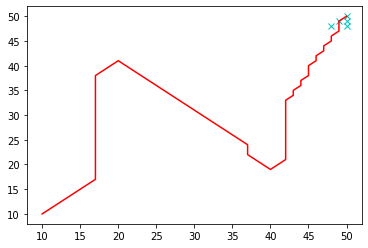

In [ ]:
import math

import matplotlib.pyplot as plt

show_animation = True


class AStarPlanner:

    def __init__(self, ox, oy, resolution, rr):
        """
        Initialize grid map for a star planning
        ox: x position list of Obstacles [m]
        oy: y position list of Obstacles [m]
        resolution: grid resolution [m]
        rr: robot radius[m]
        """

        self.resolution = resolution
        self.rr = rr
        self.min_x, self.min_y = 0, 0
        self.max_x, self.max_y = 0, 0
        self.obstacle_map = None
        self.x_width, self.y_width = 0, 0
        self.motion = self.get_motion_model()
        self.calc_obstacle_map(ox, oy)

    class Node:
        def __init__(self, x, y, cost, parent_index):
            self.x = x  # index of grid
            self.y = y  # index of grid
            self.cost = cost
            self.parent_index = parent_index

        def __str__(self):
            return str(self.x) + "," + str(self.y) + "," + str(
                self.cost) + "," + str(self.parent_index)

    def planning(self, sx, sy, gx, gy):
        """
        A star path search
        input:
            s_x: start x position [m]
            s_y: start y position [m]
            gx: goal x position [m]
            gy: goal y position [m]
        output:
            rx: x position list of the final path
            ry: y position list of the final path
        """

        start_node = self.Node(self.calc_xy_index(sx, self.min_x),
                               self.calc_xy_index(sy, self.min_y), 0.0, -1)
        goal_node = self.Node(self.calc_xy_index(gx, self.min_x),
                              self.calc_xy_index(gy, self.min_y), 0.0, -1)

        open_set, closed_set = dict(), dict()
        open_set[self.calc_grid_index(start_node)] = start_node

        while 1:
            if len(open_set) == 0:
                print("Open set is empty..")
                break

            c_id = min(
                open_set,
                key=lambda o: open_set[o].cost + self.calc_heuristic(goal_node,
                                                                     open_set[
                                                                         o]))
            current = open_set[c_id]

            # show graph
            if show_animation:  # pragma: no cover
                plt.plot(self.calc_grid_position(current.x, self.min_x),
                         self.calc_grid_position(current.y, self.min_y), "xc")
                # for stopping simulation with the esc key.
                plt.gcf().canvas.mpl_connect('key_release_event',
                                             lambda event: [exit(
                                                 0) if event.key == 'escape' else None])
                if len(closed_set.keys()) % 10 == 0:
                    plt.pause(0.001)

            if current.x == goal_node.x and current.y == goal_node.y:
                print("Find goal")
                goal_node.parent_index = current.parent_index
                goal_node.cost = current.cost
                break

            # Remove the item from the open set
            del open_set[c_id]

            # Add it to the closed set
            closed_set[c_id] = current

            # expand_grid search grid based on motion model
            for i, _ in enumerate(self.motion):
                node = self.Node(current.x + self.motion[i][0],
                                 current.y + self.motion[i][1],
                                 current.cost + self.motion[i][2], c_id)
                n_id = self.calc_grid_index(node)

                # If the node is not safe, do nothing
                if not self.verify_node(node):
                    continue

                if n_id in closed_set:
                    continue

                if n_id not in open_set:
                    open_set[n_id] = node  # discovered a new node
                else:
                    if open_set[n_id].cost > node.cost:
                        # This path is the best until now. record it
                        open_set[n_id] = node

        rx, ry = self.calc_final_path(goal_node, closed_set)

        return rx, ry

    def calc_final_path(self, goal_node, closed_set):
        # generate final course
        rx, ry = [self.calc_grid_position(goal_node.x, self.min_x)], [
            self.calc_grid_position(goal_node.y, self.min_y)]
        parent_index = goal_node.parent_index
        while parent_index != -1:
            n = closed_set[parent_index]
            rx.append(self.calc_grid_position(n.x, self.min_x))
            ry.append(self.calc_grid_position(n.y, self.min_y))
            parent_index = n.parent_index

        return rx, ry

    @staticmethod
    def calc_heuristic(n1, n2):
        w = 1.0  # weight of heuristic
        d = w * math.hypot(n1.x - n2.x, n1.y - n2.y)
        return d

    def calc_grid_position(self, index, min_position):
        """
        calc grid position
        :param index:
        :param min_position:
        :return:
        """
        pos = index * self.resolution + min_position
        return pos

    def calc_xy_index(self, position, min_pos):
        return round((position - min_pos) / self.resolution)

    def calc_grid_index(self, node):
        return (node.y - self.min_y) * self.x_width + (node.x - self.min_x)

    def verify_node(self, node):
        px = self.calc_grid_position(node.x, self.min_x)
        py = self.calc_grid_position(node.y, self.min_y)

        if px < self.min_x:
            return False
        elif py < self.min_y:
            return False
        elif px >= self.max_x:
            return False
        elif py >= self.max_y:
            return False

        # collision check
        if self.obstacle_map[node.x][node.y]:
            return False

        return True

    def calc_obstacle_map(self, ox, oy):

        self.min_x = round(min(ox))
        self.min_y = round(min(oy))
        self.max_x = round(max(ox))
        self.max_y = round(max(oy))
        print("min_x:", self.min_x)
        print("min_y:", self.min_y)
        print("max_x:", self.max_x)
        print("max_y:", self.max_y)

        self.x_width = round((self.max_x - self.min_x) / self.resolution)
        self.y_width = round((self.max_y - self.min_y) / self.resolution)
        print("x_width:", self.x_width)
        print("y_width:", self.y_width)

        # obstacle map generation
        self.obstacle_map = [[False for _ in range(self.y_width)]
                             for _ in range(self.x_width)]
        for ix in range(self.x_width):
            x = self.calc_grid_position(ix, self.min_x)
            for iy in range(self.y_width):
                y = self.calc_grid_position(iy, self.min_y)
                for iox, ioy in zip(ox, oy):
                    d = math.hypot(iox - x, ioy - y)
                    if d <= self.rr:
                        self.obstacle_map[ix][iy] = True
                        break

    @staticmethod
    def get_motion_model():
        # dx, dy, cost
        motion = [[1, 0, 1],
                  [0, 1, 1],
                  [-1, 0, 1],
                  [0, -1, 1],
                  [-1, -1, math.sqrt(2)],
                  [-1, 1, math.sqrt(2)],
                  [1, -1, math.sqrt(2)],
                  [1, 1, math.sqrt(2)]]

        return motion


def main():

    # start and goal position
    sx = 10.0  # [m]
    sy = 10.0  # [m]
    gx = 50.0  # [m]
    gy = 50.0  # [m]
    grid_size = 1.0  # [m]
    robot_radius = 1.0  # [m]

    # set obstacle positions
    ox, oy = [], []
    for i in range(-10, 60):
        ox.append(i)
        oy.append(-10.0)
    for i in range(-10, 60):
        ox.append(60.0)
        oy.append(i)
    for i in range(-10, 61):
        ox.append(i)
        oy.append(60.0)
    for i in range(-10, 61):
        ox.append(-10.0)
        oy.append(i)
    for i in range(-10, 40):
        ox.append(20.0)
        oy.append(i)
    for i in range(0, 40):
        ox.append(40.0)
        oy.append(60.0 - i)

    if show_animation:  # pragma: no cover
        plt.plot(ox, oy, ".k")
        plt.plot(sx, sy, "or")
        plt.plot(gx, gy, "xb")
        plt.grid(True)
        plt.axis("equal")

    a_star = AStarPlanner(ox, oy, grid_size, robot_radius)
    rx, ry = a_star.planning(sx, sy, gx, gy)
    print(rx,ry)

    if show_animation:  # pragma: no cover
        plt.plot(rx, ry, "-r")
        plt.pause(0.001)
        plt.show()


if __name__ == '__main__':
    main()

# RRT


In [189]:
# display.py

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_paths(gridSize, robotR, obstacles, start, goal, G, allPaths, bestPath):
	fig, ax = plt.subplots()
	
	n = obstacles.shape[0]
	# Plot obstacles
  # Human Agent Moving
	for i, obstacle in enumerate(obstacles):
    #                           x,y coord,    radius,               edgecolor.         facecolor
		ax.add_patch(patches.Circle(obstacle[:2], 0.33, alpha = i/n, edgecolor='black', facecolor='black', fill=True))

	for path in allPaths.values():
		ax.plot(path[:,0], path[:,1], linewidth=0.5, color='purple')
	# for path in allPaths:
	# 	# print(path)
	# 	ax.plot(path[:,0], path[:,1], linewidth=0.5, color='purple')

	for i in range(len(bestPath) - 1):
		path = allPaths[(bestPath[i], bestPath[i + 1])]
		ax.plot(path[:,0], path[:,1], linewidth=1, color='red')
	# if bestPath is not None and len(bestPath) > 0:
	# 	ax.plot(np.array(bestPath)[:,0], np.array(bestPath)[:,1], linewidth=0.75, color='red')

	# Plot grid
	#ax.add_patch(patches.Rectangle((0, 0), gridSize, gridSize, edgecolor='black', fill=False))

	# Plot start and goal positions
	ax.add_patch(patches.Circle(start, robotR*2, edgecolor='darkgreen', facecolor='green', fill=True))
	ax.add_patch(patches.Circle(goal, robotR*2, edgecolor='darkblue', facecolor='blue', fill=True))

	#plt.xlim([-gridSize,gridSize])
	#plt.ylim([-gridSize,gridSize])
	#plt.axis('off')
	plt.savefig("rrt.png", bbox_inches='tight')
	# plt.show()



In [ ]:
# obstacleFree.py

def ObstacleFree(x_nearest, x_new, bestU, bestT, robotR, obstacles):
	x_0, y_0, orient = x_nearest
	t = np.linspace(0, bestT, num=100)
	if bestU != 0:
		theta_t = orient + bestU * t
		x_t = x_0 + 1 * t * (np.sin(theta_t) - np.sin(orient)) / bestU
		y_t = y_0 - 1 * t * (np.cos(theta_t) - np.cos(orient)) / bestU
	else:
		theta_t = orient
		x_t = x_0 + (t * np.cos(orient))
		y_t = y_0 + (t * np.sin(orient))
	path = np.hstack((x_t[:, None], y_t[:, None]))
	obst_rad = 0.33/2
	#obst_sum = np.sum((path - obstacles[:2])**2, axis = 1)
	#if np.any(((robotR - obst_rad)**2 <= obst_sum) & (obst_sum <= (robotR + obst_rad)**2)):
	#	print("invalid")
	#	return None

#if np.min(path) < 0 or np.max(path) >= 100: return None
#for obstacle in obstacles:
#	obst_rad = #obstacle[2]
#	obst_sum = np.sum((path - obstacle[:2])**2, axis=1)
#	if np.any(((robotR - obst_rad)**2 <= obst_sum) & (obst_sum <= (robotR + obst_rad)**2)): return None
	return path

In [167]:
# path.py

def min_time_path(tree, curr, goal, path, time):
    if np.sum((np.array(curr[:2]) - np.array(goal))**2) < 25:
        return path + [curr], time
    else:
        minP = None
        minT = None
        for c in tree[curr]:
            p, t = min_time_path(tree, c[0], goal, path + [curr], time + c[1])
            if p is not None and len(p) > 0:
                if minT is None or t < minT:
                    minT = t
                    minP = p
        # p, t = options[np.argmin(options[:,1])]
        if minP is not None: path = minP
        else: path = []
        if minT is not None: time = minT
        else: time = 0
        return path, time


def best_path(G, tree, start, goal):
    # return find_shortest_path(tree, start, goal, path=[])
    return min_time_path(tree, start, goal, [], 0)[0]

In [ ]:
# steer.py

def Steer(x_nearest, x_rand, v):
	x_0, y_0, orient = x_nearest
	u = np.deg2rad(np.arange(-45, 45 + 0.5, 0.5))
	t = np.arange(0, 2 + 0.01, 0.01)
	u0 = np.where(u == 0)[0][0]
	u[u0] = 1
	theta_t = orient + u[None, :] * t[:, None]
	x_t = x_0 + v * t[:, None] * (np.sin(theta_t) - np.sin(orient)) / u
	y_t = y_0 - v * t[:, None] * (np.cos(theta_t) - np.cos(orient)) / u
	u[u0] = 0
	theta_t[:,u0] = orient
	x_t[:,u0] = x_0 + (t * np.cos(orient))
	y_t[:,u0] = y_0 + (t * np.sin(orient))
	sq_dists = (x_rand[0] - x_t)**2 + (x_rand[1] - y_t)**2
	bestT, bestU = np.unravel_index(sq_dists.argmin(), sq_dists.shape)
	return (x_t[bestT,bestU], y_t[bestT,bestU], theta_t[bestT,bestU]), np.deg2rad(bestU * 0.5 - 45), bestT * 0.01

(-2.5625898588140403, 5.558778332356671, -0.4014257279586958)
-0.2007128639793479 2.0
(-6.4560237, 6.3509064, 0.0)
-0.7853981633974483 0.0
(-0.5409300393668612, 2.385408071932485, -1.6057029118347832)
-0.6021385919380436 2.0
(-0.021214244143065386, -1.5622253170868783, -1.2740903539558606)
0.16580627893946132 2.0
(0.9424383545532229, 6.663909483018037, 1.0122909661567112)
0.7068583470577035 2.0
(4.4514034237580375, 7.47401790126814, -0.5585053606381853)
-0.7853981633974483 2.0
(-6.4560237, 6.3509064, 0.0)
-0.7853981633974483 0.0
(7.960368492962853, 8.284126319518242, 1.0122909661567112)
0.7853981633974483 2.0
(-6.4560237, 6.3509064, 0.0)
-0.7853981633974483 0.0
(-1.7119058759347152, -4.7419538137370125, -2.844886680750757)
-0.7853981633974483 2.0
(10.253626053815674, 11.55923753399649, 0.9075712110370514)
-0.05235987755982989 2.0
(-6.4560237, 6.3509064, 0.0)
-0.7853981633974483 0.0
(-6.4560237, 6.3509064, 0.0)
-0.7853981633974483 0.0
(-6.4560237, 6.3509064, 0.0)
-0.7853981633974483 0.0

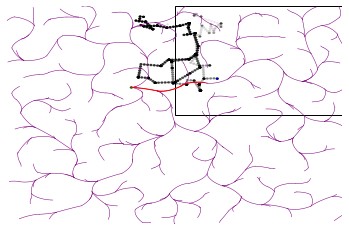

In [ ]:
import random

def SampleFree(gridSize):
    return (random.uniform(-gridSize, gridSize), random.uniform(-gridSize, gridSize))

def Nearest(G, x_rand):
    curr_distance = None
    x_nearest = None
    for v in G[0]:
        squared_distance = (v[0] - x_rand[0]) ** 2 + (v[1] - x_rand[1]) ** 2
        if curr_distance is None or squared_distance < curr_distance:
            curr_distance = squared_distance
            x_nearest = v
    return x_nearest

start_pos = np.array([-6.4560237,  0.0099186,  6.3509064])
goals = np.array([[6.3640614,  0.20991862, 8.366385  ],
    [-3.2659068,   0.20508613, 19.700174  ],
    [-0.47940367,  0.20991862, 15.373854  ],
    [-7.109163,    0.35362667, 22.990005  ],
    [-0.5511527,   0.00991862,  6.142468  ]])

goals = np.vstack((goals, start_pos))

start_pos = np.delete(start_pos, 1) # leaving [-6.4560237,  6.3509064]
goals = np.delete(goals, 1, 1) # column 1 delted

start = tuple(list(start_pos) + [0]) # x0, y0, orient
goal = goals[0]



gridSize = 25
robotR = 0.33/2
v = 1

# Castle
obstacles = PK.copy()

obstacles = np.asarray(obstacles) # (717, 3)
obstacles = np.delete(obstacles, 1, 1) # (717, 2)
N = obstacles.shape[0] # 717


x_init = start
V = {x_init}
tree = {x_init: []}
E = []
allPaths = {}
for i in range(N):
    x_rand = SampleFree(gridSize) # tuple (xx.xxxx, yy.yyyy)
    x_nearest = Nearest((V, E), x_rand) # tuple (xx.xxxx, yy.yyyy)
    x_new, bestU, bestT = Steer(x_nearest, x_rand, v) 
    #print(x_new) # tuple (xx.xxxx, yy.yyyy, zz.zzzz)
    #print(bestU, bestT) # float, float
    if x_new == x_nearest: continue
    path = ObstacleFree(x_nearest, x_new, bestU, bestT, robotR, obstacles[i])
    if path is not None:
        V.add(x_new)
        E.append([x_nearest, x_new])
        tree[x_nearest].append((x_new, bestT))
        if x_new not in tree: tree[x_new] = []
        allPaths[(x_nearest, x_new)] = path

bestPath = best_path((V, E), tree, x_init, goal)
print(bestPath)
print(bestT)

plot_paths(gridSize, robotR, obstacles, x_init, goal, (V, E), allPaths, bestPath)





[[-4.86510658, 0.20991862, 15.50925732], [-5.34234762, 0.20991862, 15.658391], [-5.81958866, 0.20991862, 15.80752468], [-5.81958866, 0.20991862, 15.80752468], [-5.81958866, 0.20991862, 15.80752468], [-5.81958866, 0.20991862, 15.80752468], [-5.81958866, 0.20991862, 15.80752468], [-5.81958866, 0.20991862, 15.80752468], [-5.81958866, 0.20991862, 15.80752468], [-5.81958866, 0.20991862, 15.80752468], [-5.81958866, 0.20991862, 15.80752468], [-5.81958866, 0.20991862, 15.80752468], [-5.81958866, 0.20991862, 15.80752468], [-5.81958866, 0.20991862, 15.80752468], [-5.33171892, 0.20991862, 15.91699123], [-4.84384918, 0.20991862, 16.02645874], [-4.35597944, 0.20991862, 16.13592529], [-3.86810946, 0.2099186, 16.24539185], [-3.38023949, 0.22444601, 16.3548584], [-2.89236951, 0.29136491, 16.46432495], [-2.40449953, 0.25109407, 16.5737915], [-2.40449953, 0.25109407, 16.5737915], [-2.40449953, 0.25109407, 16.5737915], [-2.40449953, 0.25109407, 16.5737915], [-2.40449953, 0.25109407, 16.5737915], [-2.4044

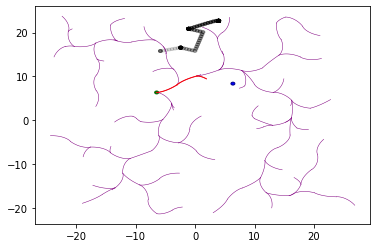

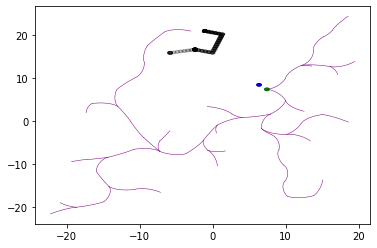

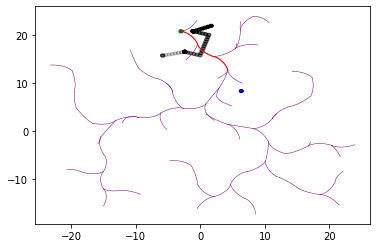

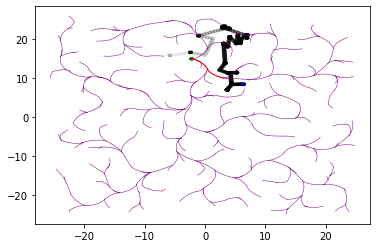

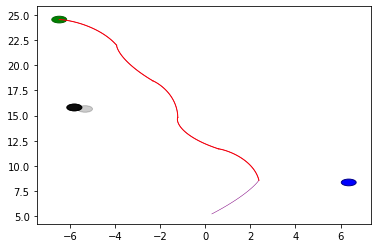

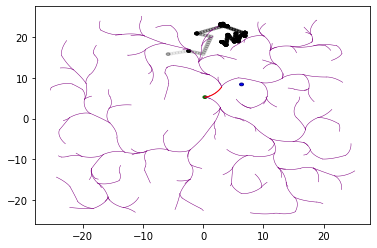

In [195]:
start_pos = np.array([-6.4560237,  0.0099186,  6.3509064])
goals = np.array([[6.3640614,  0.20991862, 8.366385  ],
        [-3.2659068,   0.20508613, 19.700174  ],
        [-0.47940367,  0.20991862, 15.373854  ],
        [-7.109163,    0.35362667, 22.990005  ],
        [-0.5511527,   0.00991862,  6.142468  ]])
goals = np.vstack((goals, start_pos))

start_pos = np.delete(start_pos, 1)
goals = np.delete(goals, 1, 1)

print(PK)
obstacles = PK.copy()
obstacles = np.asarray(obstacles) # (717, 3)
obstacles = np.delete(obstacles, 1, 1) # (717, 2)

x = np.append(start_pos, np.array([np.pi / 8, 0, 0]))
print(x)

humans = load_humans()

# dt = 1 / 60 # default
numT = 5
dt = 1 / numT
time_step = 0

# Human, Stationary
collisionCounts = [0, 0]

# Total distance traveled
totalDistance = 0
grid_size = 2.0  # [m]
robot_radius = 0.165  # [m]
# Entire path taken
totalTrajectory = None
show_animation = True

x_init = (x[0], x[1], 0)
V = {x_init}
tree = {x_init: []}
E = []
allPaths = {}

 

while len(goals) > 0:
    trajectory = np.array(x)
    goal_pos = goals[0]
    goals = np.delete(goals, 0, 0)
    x_init = (x[0], x[1], 0)
    V = {x_init}
    tree = {x_init: []}
    E = []
    allPaths = {}        
    print("============================================")
    print("Finding goal_pos: ", goal_pos)
    print("Time start: ", time_step)
    st_timestep = time_step
    while True:
        
        ob = load_obstacles(humans, time_step, numT) # (4,2) np.array
        ox = [ob[0][0],ob[1][0]]
        oy = [ob[0][1],ob[1][1]]
        #print(ob.shape)
        if hasCollided(x[:2], ob):
            collisionCounts[0] += 1
        # u, predicted_trajectory = dwa_control(x, goal_pos, ob, dt)
        x_rand = SampleFree(gridSize) # (x,y)
        x_nearest = Nearest((V, E), x_rand) # (x,y)
        x_new, bestU, bestT = Steer(x_nearest, x_rand, v) # (x,y,z), float, float
        if x_new == x_nearest: continue
        path = ObstacleFree(x_nearest, x_new, bestU, bestT, robotR, ob[-1])

        if path is not None:
          V.add(x_new)
          E.append([x_nearest, x_new])
          tree[x_nearest].append((x_new, bestT))
          if x_new not in tree: tree[x_new] = []
          allPaths[(x_nearest, x_new)] = path

        dist_to_goal = math.hypot(path[-1][0] - goal_pos[0], path[-1][1] - goal_pos[1])
        #print("dist_to_goal", dist_to_goal)
        
        if dist_to_goal <= 2:
            print("Goal!!")
            break
        time_step += 1
    x = tuple(list(x_new) + [0, 0])
    end_timestep = time_step
    print("Start is:", x[0], x[1] )
    #print(x[0], x[1], goal_pos[0], goal_pos[1],ox, oy)
    #print(ob.shape)

    bestPath = best_path((V, E), tree, x_init, goal)
    #print(bestPath)
    #print((end_timestep - st_timestep))
    plot_paths(gridSize, robotR, obstacles[:(end_timestep - st_timestep)], x_init, goal, (V, E), allPaths, bestPath)
        

       
    if totalTrajectory is None:
        totalTrajectory = trajectory
    else:
        totalTrajectory = np.vstack((totalTrajectory, trajectory))
    print("Found goal_pos")
    print("Collision Count: ", collisionCounts)
    print("Time lap: ", time_step)
    print("Distance traveled: ", totalDistance)
    print("============================================")
    print("\n")

print("Done")
print("Collision Count: ", collisionCounts)
print("Time taken: ", time_step)
print("Distance traveled: ", totalDistance)